# Sciplex Dose

In [1]:
ood_seed = 1

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('BMS', '10.0'), 153)

Removed datapoint: 153


In [11]:
adata

AnnData object with n_obs × n_vars = 14658 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed_expression-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
  rank_zero_warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1454,3567,2192,2780,1734
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 332,901,568,709,421
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:06<1:00:02,  6.01s/it]

Epoch 1/600:   0%|          | 1/600 [00:06<1:00:02,  6.01s/it, v_num=1, total_loss_train=2.69e+3, kl_local_train=36.9]

Epoch 2/600:   0%|          | 1/600 [00:06<1:00:02,  6.01s/it, v_num=1, total_loss_train=2.69e+3, kl_local_train=36.9]

Epoch 2/600:   0%|          | 2/600 [00:11<57:47,  5.80s/it, v_num=1, total_loss_train=2.69e+3, kl_local_train=36.9]  

Epoch 2/600:   0%|          | 2/600 [00:11<57:47,  5.80s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=65.1]

Epoch 3/600:   0%|          | 2/600 [00:11<57:47,  5.80s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=65.1]

Epoch 3/600:   0%|          | 3/600 [00:17<56:47,  5.71s/it, v_num=1, total_loss_train=2.24e+3, kl_local_train=65.1]

Epoch 3/600:   0%|          | 3/600 [00:17<56:47,  5.71s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=70.4]

Epoch 4/600:   0%|          | 3/600 [00:17<56:47,  5.71s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=70.4]

Epoch 4/600:   1%|          | 4/600 [00:23<56:49,  5.72s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=70.4]

Epoch 4/600:   1%|          | 4/600 [00:23<56:49,  5.72s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=69.7]

Epoch 5/600:   1%|          | 4/600 [00:23<56:49,  5.72s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=69.7]

Epoch 5/600:   1%|          | 5/600 [00:29<57:59,  5.85s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=69.7]

Epoch 5/600:   1%|          | 5/600 [00:29<57:59,  5.85s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=62.9]

Epoch 6/600:   1%|          | 5/600 [00:29<57:59,  5.85s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=62.9]

Epoch 6/600:   1%|          | 6/600 [00:34<57:47,  5.84s/it, v_num=1, total_loss_train=2.21e+3, kl_local_train=62.9]

Epoch 6/600:   1%|          | 6/600 [00:34<57:47,  5.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 7/600:   1%|          | 6/600 [00:34<57:47,  5.84s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 7/600:   1%|          | 7/600 [00:40<56:10,  5.68s/it, v_num=1, total_loss_train=2.19e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 7/600:   1%|          | 7/600 [00:40<56:10,  5.68s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 8/600:   1%|          | 7/600 [00:40<56:10,  5.68s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 8/600:   1%|▏         | 8/600 [00:45<55:06,  5.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 8/600:   1%|▏         | 8/600 [00:45<55:06,  5.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 9/600:   1%|▏         | 8/600 [00:45<55:06,  5.58s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 9/600:   2%|▏         | 9/600 [00:51<54:23,  5.52s/it, v_num=1, total_loss_train=2.16e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 9/600:   2%|▏         | 9/600 [00:51<54:23,  5.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 10/600:   2%|▏         | 9/600 [00:51<54:23,  5.52s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 10/600:   2%|▏         | 10/600 [00:56<54:43,  5.56s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 10/600:   2%|▏         | 10/600 [00:56<54:43,  5.56s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 11/600:   2%|▏         | 10/600 [00:57<54:43,  5.56s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 11/600:   2%|▏         | 11/600 [01:02<55:08,  5.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0405, metric_mi|condition_train=0.0453]

Epoch 11/600:   2%|▏         | 11/600 [01:02<55:08,  5.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201] 

Epoch 12/600:   2%|▏         | 11/600 [01:02<55:08,  5.62s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 12/600:   2%|▏         | 12/600 [01:07<54:01,  5.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 12/600:   2%|▏         | 12/600 [01:07<54:01,  5.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 13/600:   2%|▏         | 12/600 [01:07<54:01,  5.51s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 13/600:   2%|▏         | 13/600 [01:12<52:55,  5.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 13/600:   2%|▏         | 13/600 [01:12<52:55,  5.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 14/600:   2%|▏         | 13/600 [01:12<52:55,  5.41s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 14/600:   2%|▏         | 14/600 [01:17<51:57,  5.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 14/600:   2%|▏         | 14/600 [01:17<51:57,  5.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 15/600:   2%|▏         | 14/600 [01:17<51:57,  5.32s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 15/600:   2%|▎         | 15/600 [01:23<52:02,  5.34s/it, v_num=1, total_loss_train=2.15e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 15/600:   2%|▎         | 15/600 [01:23<52:02,  5.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 16/600:   2%|▎         | 15/600 [01:23<52:02,  5.34s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 16/600:   3%|▎         | 16/600 [01:28<52:30,  5.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.0703, metric_mi|condition_train=0.201]

Epoch 16/600:   3%|▎         | 16/600 [01:28<52:30,  5.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 17/600:   3%|▎         | 16/600 [01:28<52:30,  5.39s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 17/600:   3%|▎         | 17/600 [01:33<51:21,  5.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 17/600:   3%|▎         | 17/600 [01:33<51:21,  5.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 18/600:   3%|▎         | 17/600 [01:33<51:21,  5.29s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 18/600:   3%|▎         | 18/600 [01:38<50:40,  5.22s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=78.7, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 18/600:   3%|▎         | 18/600 [01:38<50:40,  5.22s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 19/600:   3%|▎         | 18/600 [01:39<50:40,  5.22s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 19/600:   3%|▎         | 19/600 [01:44<50:06,  5.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 19/600:   3%|▎         | 19/600 [01:44<50:06,  5.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 20/600:   3%|▎         | 19/600 [01:44<50:06,  5.17s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 20/600:   3%|▎         | 20/600 [01:49<50:26,  5.22s/it, v_num=1, total_loss_train=2.14e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 20/600:   3%|▎         | 20/600 [01:49<50:26,  5.22s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 21/600:   3%|▎         | 20/600 [01:49<50:26,  5.22s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 21/600:   4%|▎         | 21/600 [01:54<51:14,  5.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.167]

Epoch 21/600:   4%|▎         | 21/600 [01:54<51:14,  5.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 22/600:   4%|▎         | 21/600 [01:54<51:14,  5.31s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 22/600:   4%|▎         | 22/600 [01:59<50:28,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 22/600:   4%|▎         | 22/600 [01:59<50:28,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 23/600:   4%|▎         | 22/600 [01:59<50:28,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 23/600:   4%|▍         | 23/600 [02:05<49:49,  5.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 23/600:   4%|▍         | 23/600 [02:05<49:49,  5.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 24/600:   4%|▍         | 23/600 [02:05<49:49,  5.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 24/600:   4%|▍         | 24/600 [02:10<49:12,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 24/600:   4%|▍         | 24/600 [02:10<49:12,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 25/600:   4%|▍         | 24/600 [02:10<49:12,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 25/600:   4%|▍         | 25/600 [02:15<49:32,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 25/600:   4%|▍         | 25/600 [02:15<49:32,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 26/600:   4%|▍         | 25/600 [02:15<49:32,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 26/600:   4%|▍         | 26/600 [02:20<50:18,  5.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.164]

Epoch 26/600:   4%|▍         | 26/600 [02:20<50:18,  5.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 27/600:   4%|▍         | 26/600 [02:20<50:18,  5.26s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 27/600:   4%|▍         | 27/600 [02:25<49:27,  5.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.3, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 27/600:   4%|▍         | 27/600 [02:25<49:27,  5.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 28/600:   4%|▍         | 27/600 [02:25<49:27,  5.18s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 28/600:   5%|▍         | 28/600 [02:30<48:48,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 28/600:   5%|▍         | 28/600 [02:30<48:48,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 29/600:   5%|▍         | 28/600 [02:30<48:48,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 29/600:   5%|▍         | 29/600 [02:35<48:22,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 29/600:   5%|▍         | 29/600 [02:35<48:22,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 30/600:   5%|▍         | 29/600 [02:35<48:22,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 30/600:   5%|▌         | 30/600 [02:40<48:46,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=92.8, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 30/600:   5%|▌         | 30/600 [02:40<48:46,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 31/600:   5%|▌         | 30/600 [02:41<48:46,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 31/600:   5%|▌         | 31/600 [02:46<49:35,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0893, metric_mi|condition_train=0.205]

Epoch 31/600:   5%|▌         | 31/600 [02:46<49:35,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 32/600:   5%|▌         | 31/600 [02:46<49:35,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 32/600:   5%|▌         | 32/600 [02:51<48:50,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.1, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 32/600:   5%|▌         | 32/600 [02:51<48:50,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 33/600:   5%|▌         | 32/600 [02:51<48:50,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 33/600:   6%|▌         | 33/600 [02:56<48:17,  5.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 33/600:   6%|▌         | 33/600 [02:56<48:17,  5.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 34/600:   6%|▌         | 33/600 [02:56<48:17,  5.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 34/600:   6%|▌         | 34/600 [03:01<47:53,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 34/600:   6%|▌         | 34/600 [03:01<47:53,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 35/600:   6%|▌         | 34/600 [03:01<47:53,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 35/600:   6%|▌         | 35/600 [03:06<48:16,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 35/600:   6%|▌         | 35/600 [03:06<48:16,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 36/600:   6%|▌         | 35/600 [03:07<48:16,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 36/600:   6%|▌         | 36/600 [03:12<49:07,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.225]

Epoch 36/600:   6%|▌         | 36/600 [03:12<49:07,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 37/600:   6%|▌         | 36/600 [03:12<49:07,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 37/600:   6%|▌         | 37/600 [03:17<48:24,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 37/600:   6%|▌         | 37/600 [03:17<48:24,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 38/600:   6%|▌         | 37/600 [03:17<48:24,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 38/600:   6%|▋         | 38/600 [03:22<47:53,  5.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 38/600:   6%|▋         | 38/600 [03:22<47:53,  5.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]  

Epoch 39/600:   6%|▋         | 38/600 [03:22<47:53,  5.11s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 39/600:   6%|▋         | 39/600 [03:27<47:28,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 39/600:   6%|▋         | 39/600 [03:27<47:28,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 40/600:   6%|▋         | 39/600 [03:27<47:28,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 40/600:   7%|▋         | 40/600 [03:32<47:57,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 40/600:   7%|▋         | 40/600 [03:32<47:57,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 41/600:   7%|▋         | 40/600 [03:32<47:57,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 41/600:   7%|▋         | 41/600 [03:37<48:46,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0977, metric_mi|condition_train=0.237]

Epoch 41/600:   7%|▋         | 41/600 [03:37<48:46,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 42/600:   7%|▋         | 41/600 [03:37<48:46,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 42/600:   7%|▋         | 42/600 [03:42<48:02,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.3, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 42/600:   7%|▋         | 42/600 [03:42<48:02,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 43/600:   7%|▋         | 42/600 [03:42<48:02,  5.16s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 43/600:   7%|▋         | 43/600 [03:47<47:29,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.6, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 43/600:   7%|▋         | 43/600 [03:47<47:29,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 44/600:   7%|▋         | 43/600 [03:47<47:29,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 44/600:   7%|▋         | 44/600 [03:52<47:05,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 44/600:   7%|▋         | 44/600 [03:52<47:05,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 45/600:   7%|▋         | 44/600 [03:52<47:05,  5.08s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 45/600:   8%|▊         | 45/600 [03:58<47:28,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 45/600:   8%|▊         | 45/600 [03:58<47:28,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 46/600:   8%|▊         | 45/600 [03:58<47:28,  5.13s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 46/600:   8%|▊         | 46/600 [04:03<48:20,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.9, metric_mi|dose_training_train=0.0947, metric_mi|condition_train=0.238]

Epoch 46/600:   8%|▊         | 46/600 [04:03<48:20,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 47/600:   8%|▊         | 46/600 [04:03<48:20,  5.23s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 47/600:   8%|▊         | 47/600 [04:08<47:39,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.7, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 47/600:   8%|▊         | 47/600 [04:08<47:39,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 48/600:   8%|▊         | 47/600 [04:08<47:39,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 48/600:   8%|▊         | 48/600 [04:13<47:08,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 48/600:   8%|▊         | 48/600 [04:13<47:08,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 49/600:   8%|▊         | 48/600 [04:13<47:08,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 49/600:   8%|▊         | 49/600 [04:18<46:44,  5.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 49/600:   8%|▊         | 49/600 [04:18<46:44,  5.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]  

Epoch 50/600:   8%|▊         | 49/600 [04:18<46:44,  5.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 50/600:   8%|▊         | 50/600 [04:23<47:06,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 50/600:   8%|▊         | 50/600 [04:23<47:06,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 51/600:   8%|▊         | 50/600 [04:24<47:06,  5.14s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 51/600:   8%|▊         | 51/600 [04:29<47:55,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.233]

Epoch 51/600:   8%|▊         | 51/600 [04:29<47:55,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23] 

Epoch 52/600:   8%|▊         | 51/600 [04:29<47:55,  5.24s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 52/600:   9%|▊         | 52/600 [04:34<47:12,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 52/600:   9%|▊         | 52/600 [04:34<47:12,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 53/600:   9%|▊         | 52/600 [04:34<47:12,  5.17s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 53/600:   9%|▉         | 53/600 [04:39<46:40,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 53/600:   9%|▉         | 53/600 [04:39<46:40,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 54/600:   9%|▉         | 53/600 [04:39<46:40,  5.12s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 54/600:   9%|▉         | 54/600 [04:44<46:18,  5.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 54/600:   9%|▉         | 54/600 [04:44<46:18,  5.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 55/600:   9%|▉         | 54/600 [04:44<46:18,  5.09s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 55/600:   9%|▉         | 55/600 [04:49<46:44,  5.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 55/600:   9%|▉         | 55/600 [04:49<46:44,  5.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 56/600:   9%|▉         | 55/600 [04:50<46:44,  5.15s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 56/600:   9%|▉         | 56/600 [04:55<47:45,  5.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.23]

Epoch 56/600:   9%|▉         | 56/600 [04:55<47:45,  5.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225] 

Epoch 57/600:   9%|▉         | 56/600 [04:55<47:45,  5.27s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 57/600:  10%|▉         | 57/600 [05:00<47:03,  5.20s/it, v_num=1, total_loss_train=2.13e+3, kl_local_train=88, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 57/600:  10%|▉         | 57/600 [05:00<47:03,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 58/600:  10%|▉         | 57/600 [05:00<47:03,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 58/600:  10%|▉         | 58/600 [05:05<46:58,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 58/600:  10%|▉         | 58/600 [05:05<46:58,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 59/600:  10%|▉         | 58/600 [05:05<46:58,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 59/600:  10%|▉         | 59/600 [05:10<46:24,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 59/600:  10%|▉         | 59/600 [05:10<46:24,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 60/600:  10%|▉         | 59/600 [05:10<46:24,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 60/600:  10%|█         | 60/600 [05:15<46:35,  5.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 60/600:  10%|█         | 60/600 [05:15<46:35,  5.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 61/600:  10%|█         | 60/600 [05:16<46:35,  5.18s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 61/600:  10%|█         | 61/600 [05:21<47:21,  5.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.225]

Epoch 61/600:  10%|█         | 61/600 [05:21<47:21,  5.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 62/600:  10%|█         | 61/600 [05:21<47:21,  5.27s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 62/600:  10%|█         | 62/600 [05:26<46:37,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 62/600:  10%|█         | 62/600 [05:26<46:37,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 63/600:  10%|█         | 62/600 [05:26<46:37,  5.20s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 63/600:  10%|█         | 63/600 [05:31<46:05,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 63/600:  10%|█         | 63/600 [05:31<46:05,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 64/600:  10%|█         | 63/600 [05:31<46:05,  5.15s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 64/600:  11%|█         | 64/600 [05:36<45:38,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.7, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 64/600:  11%|█         | 64/600 [05:36<45:38,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 65/600:  11%|█         | 64/600 [05:36<45:38,  5.11s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 65/600:  11%|█         | 65/600 [05:41<46:00,  5.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 65/600:  11%|█         | 65/600 [05:41<46:00,  5.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 66/600:  11%|█         | 65/600 [05:42<46:00,  5.16s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 66/600:  11%|█         | 66/600 [05:47<46:48,  5.26s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.0855, metric_mi|condition_train=0.225]

Epoch 66/600:  11%|█         | 66/600 [05:47<46:48,  5.26s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 67/600:  11%|█         | 66/600 [05:47<46:48,  5.26s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 67/600:  11%|█         | 67/600 [05:52<46:05,  5.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 67/600:  11%|█         | 67/600 [05:52<46:05,  5.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 68/600:  11%|█         | 67/600 [05:52<46:05,  5.19s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 68/600:  11%|█▏        | 68/600 [05:57<45:33,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 68/600:  11%|█▏        | 68/600 [05:57<45:33,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 69/600:  11%|█▏        | 68/600 [05:57<45:33,  5.14s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 69/600:  12%|█▏        | 69/600 [06:02<45:10,  5.10s/it, v_num=1, total_loss_train=2.12e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 69/600:  12%|█▏        | 69/600 [06:02<45:10,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 70/600:  12%|█▏        | 69/600 [06:02<45:10,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 70/600:  12%|█▏        | 70/600 [06:07<45:27,  5.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 70/600:  12%|█▏        | 70/600 [06:07<45:27,  5.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 71/600:  12%|█▏        | 70/600 [06:07<45:27,  5.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 71/600:  12%|█▏        | 71/600 [06:12<46:17,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.233]

Epoch 71/600:  12%|█▏        | 71/600 [06:12<46:17,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 72/600:  12%|█▏        | 71/600 [06:12<46:17,  5.25s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 72/600:  12%|█▏        | 72/600 [06:17<45:37,  5.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.9, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 72/600:  12%|█▏        | 72/600 [06:17<45:37,  5.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 73/600:  12%|█▏        | 72/600 [06:17<45:37,  5.18s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 73/600:  12%|█▏        | 73/600 [06:22<45:07,  5.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 73/600:  12%|█▏        | 73/600 [06:22<45:07,  5.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 74/600:  12%|█▏        | 73/600 [06:22<45:07,  5.14s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 74/600:  12%|█▏        | 74/600 [06:27<44:44,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 74/600:  12%|█▏        | 74/600 [06:27<44:44,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 75/600:  12%|█▏        | 74/600 [06:27<44:44,  5.10s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 75/600:  12%|█▎        | 75/600 [06:33<45:04,  5.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 75/600:  12%|█▎        | 75/600 [06:33<45:04,  5.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 76/600:  12%|█▎        | 75/600 [06:33<45:04,  5.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 76/600:  13%|█▎        | 76/600 [06:38<46:06,  5.28s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.0963, metric_mi|condition_train=0.235]

Epoch 76/600:  13%|█▎        | 76/600 [06:38<46:06,  5.28s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234] 

Epoch 77/600:  13%|█▎        | 76/600 [06:38<46:06,  5.28s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 77/600:  13%|█▎        | 77/600 [06:43<45:23,  5.21s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 77/600:  13%|█▎        | 77/600 [06:43<45:23,  5.21s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 78/600:  13%|█▎        | 77/600 [06:43<45:23,  5.21s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 78/600:  13%|█▎        | 78/600 [06:48<44:51,  5.16s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 78/600:  13%|█▎        | 78/600 [06:48<44:51,  5.16s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 79/600:  13%|█▎        | 78/600 [06:48<44:51,  5.16s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 79/600:  13%|█▎        | 79/600 [06:53<44:27,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 79/600:  13%|█▎        | 79/600 [06:53<44:27,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]  

Epoch 80/600:  13%|█▎        | 79/600 [06:53<44:27,  5.12s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 80/600:  13%|█▎        | 80/600 [06:59<44:44,  5.16s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 80/600:  13%|█▎        | 80/600 [06:59<44:44,  5.16s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 81/600:  13%|█▎        | 80/600 [06:59<44:44,  5.16s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 81/600:  14%|█▎        | 81/600 [07:04<45:30,  5.26s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.234]

Epoch 81/600:  14%|█▎        | 81/600 [07:04<45:30,  5.26s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 82/600:  14%|█▎        | 81/600 [07:04<45:30,  5.26s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 82/600:  14%|█▎        | 82/600 [07:09<44:49,  5.19s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 82/600:  14%|█▎        | 82/600 [07:09<44:49,  5.19s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 83/600:  14%|█▎        | 82/600 [07:09<44:49,  5.19s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 83/600:  14%|█▍        | 83/600 [07:14<44:20,  5.15s/it, v_num=1, total_loss_train=2.11e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 83/600:  14%|█▍        | 83/600 [07:14<44:20,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241] 

Epoch 84/600:  14%|█▍        | 83/600 [07:14<44:20,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 84/600:  14%|█▍        | 84/600 [07:19<43:57,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 84/600:  14%|█▍        | 84/600 [07:19<43:57,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 85/600:  14%|█▍        | 84/600 [07:19<43:57,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 85/600:  14%|█▍        | 85/600 [07:25<44:13,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=79.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 85/600:  14%|█▍        | 85/600 [07:25<44:13,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 86/600:  14%|█▍        | 85/600 [07:25<44:13,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 86/600:  14%|█▍        | 86/600 [07:30<45:01,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.241]

Epoch 86/600:  14%|█▍        | 86/600 [07:30<45:01,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 87/600:  14%|█▍        | 86/600 [07:30<45:01,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 87/600:  14%|█▍        | 87/600 [07:35<44:22,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 87/600:  14%|█▍        | 87/600 [07:35<44:22,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 88/600:  14%|█▍        | 87/600 [07:35<44:22,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 88/600:  15%|█▍        | 88/600 [07:40<43:53,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 88/600:  15%|█▍        | 88/600 [07:40<43:53,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]  

Epoch 89/600:  15%|█▍        | 88/600 [07:40<43:53,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 89/600:  15%|█▍        | 89/600 [07:45<43:31,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 89/600:  15%|█▍        | 89/600 [07:45<43:31,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 90/600:  15%|█▍        | 89/600 [07:45<43:31,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 90/600:  15%|█▌        | 90/600 [07:50<43:49,  5.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=78, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 90/600:  15%|█▌        | 90/600 [07:50<43:49,  5.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 91/600:  15%|█▌        | 90/600 [07:51<43:49,  5.16s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 91/600:  15%|█▌        | 91/600 [07:56<44:36,  5.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.241]

Epoch 91/600:  15%|█▌        | 91/600 [07:56<44:36,  5.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248] 

Epoch 92/600:  15%|█▌        | 91/600 [07:56<44:36,  5.26s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 92/600:  15%|█▌        | 92/600 [08:01<43:57,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 92/600:  15%|█▌        | 92/600 [08:01<43:57,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]  

Epoch 93/600:  15%|█▌        | 92/600 [08:01<43:57,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 93/600:  16%|█▌        | 93/600 [08:06<43:28,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 93/600:  16%|█▌        | 93/600 [08:06<43:28,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 94/600:  16%|█▌        | 93/600 [08:06<43:28,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 94/600:  16%|█▌        | 94/600 [08:11<43:04,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=77.5, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 94/600:  16%|█▌        | 94/600 [08:11<43:04,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 95/600:  16%|█▌        | 94/600 [08:11<43:04,  5.11s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 95/600:  16%|█▌        | 95/600 [08:16<43:20,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 95/600:  16%|█▌        | 95/600 [08:16<43:20,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 96/600:  16%|█▌        | 95/600 [08:17<43:20,  5.15s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 96/600:  16%|█▌        | 96/600 [08:22<44:06,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.248]

Epoch 96/600:  16%|█▌        | 96/600 [08:22<44:06,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 97/600:  16%|█▌        | 96/600 [08:22<44:06,  5.25s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 97/600:  16%|█▌        | 97/600 [08:27<43:29,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 97/600:  16%|█▌        | 97/600 [08:27<43:29,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 98/600:  16%|█▌        | 97/600 [08:27<43:29,  5.19s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 98/600:  16%|█▋        | 98/600 [08:32<43:01,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 98/600:  16%|█▋        | 98/600 [08:32<43:01,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 99/600:  16%|█▋        | 98/600 [08:32<43:01,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 99/600:  16%|█▋        | 99/600 [08:37<42:55,  5.14s/it, v_num=1, total_loss_train=2.1e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 99/600:  16%|█▋        | 99/600 [08:37<42:55,  5.14s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246] 

Epoch 100/600:  16%|█▋        | 99/600 [08:37<42:55,  5.14s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 100/600:  17%|█▋        | 100/600 [08:42<43:07,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 100/600:  17%|█▋        | 100/600 [08:42<43:07,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 101/600:  17%|█▋        | 100/600 [08:43<43:07,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 101/600:  17%|█▋        | 101/600 [08:48<43:50,  5.27s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75, metric_mi|dose_training_train=0.0962, metric_mi|condition_train=0.246]

Epoch 101/600:  17%|█▋        | 101/600 [08:48<43:50,  5.27s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 102/600:  17%|█▋        | 101/600 [08:48<43:50,  5.27s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 102/600:  17%|█▋        | 102/600 [08:53<43:10,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 102/600:  17%|█▋        | 102/600 [08:53<43:10,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 103/600:  17%|█▋        | 102/600 [08:53<43:10,  5.20s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 103/600:  17%|█▋        | 103/600 [08:58<42:40,  5.15s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 103/600:  17%|█▋        | 103/600 [08:58<42:40,  5.15s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 104/600:  17%|█▋        | 103/600 [08:58<42:40,  5.15s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 104/600:  17%|█▋        | 104/600 [09:03<42:17,  5.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 104/600:  17%|█▋        | 104/600 [09:03<42:17,  5.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 105/600:  17%|█▋        | 104/600 [09:03<42:17,  5.12s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 105/600:  18%|█▊        | 105/600 [09:08<42:42,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 105/600:  18%|█▊        | 105/600 [09:08<42:42,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 106/600:  18%|█▊        | 105/600 [09:09<42:42,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 106/600:  18%|█▊        | 106/600 [09:14<43:26,  5.28s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.239]

Epoch 106/600:  18%|█▊        | 106/600 [09:14<43:26,  5.28s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 107/600:  18%|█▊        | 106/600 [09:14<43:26,  5.28s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 107/600:  18%|█▊        | 107/600 [09:19<42:47,  5.21s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.7, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 107/600:  18%|█▊        | 107/600 [09:19<42:47,  5.21s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 108/600:  18%|█▊        | 107/600 [09:19<42:47,  5.21s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 108/600:  18%|█▊        | 108/600 [09:24<42:19,  5.16s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 108/600:  18%|█▊        | 108/600 [09:24<42:19,  5.16s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 109/600:  18%|█▊        | 108/600 [09:24<42:19,  5.16s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 109/600:  18%|█▊        | 109/600 [09:29<41:57,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 109/600:  18%|█▊        | 109/600 [09:29<41:57,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 110/600:  18%|█▊        | 109/600 [09:29<41:57,  5.13s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 110/600:  18%|█▊        | 110/600 [09:34<42:13,  5.17s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 110/600:  18%|█▊        | 110/600 [09:34<42:13,  5.17s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]  

Epoch 111/600:  18%|█▊        | 110/600 [09:34<42:13,  5.17s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 111/600:  18%|█▊        | 111/600 [09:40<43:09,  5.30s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73, metric_mi|dose_training_train=0.0862, metric_mi|condition_train=0.227]

Epoch 111/600:  18%|█▊        | 111/600 [09:40<43:09,  5.30s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 112/600:  18%|█▊        | 111/600 [09:40<43:09,  5.30s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 112/600:  19%|█▊        | 112/600 [09:45<42:38,  5.24s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 112/600:  19%|█▊        | 112/600 [09:45<42:38,  5.24s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 113/600:  19%|█▊        | 112/600 [09:45<42:38,  5.24s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 113/600:  19%|█▉        | 113/600 [09:50<42:17,  5.21s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 113/600:  19%|█▉        | 113/600 [09:50<42:17,  5.21s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 114/600:  19%|█▉        | 113/600 [09:50<42:17,  5.21s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 114/600:  19%|█▉        | 114/600 [09:55<41:58,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 114/600:  19%|█▉        | 114/600 [09:55<41:58,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 115/600:  19%|█▉        | 114/600 [09:55<41:58,  5.18s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 115/600:  19%|█▉        | 115/600 [10:00<42:09,  5.22s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 115/600:  19%|█▉        | 115/600 [10:00<42:09,  5.22s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 116/600:  19%|█▉        | 115/600 [10:01<42:09,  5.22s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 116/600:  19%|█▉        | 116/600 [10:06<42:56,  5.32s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.219]

Epoch 116/600:  19%|█▉        | 116/600 [10:06<42:56,  5.32s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 117/600:  19%|█▉        | 116/600 [10:06<42:56,  5.32s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 117/600:  20%|█▉        | 117/600 [10:11<42:23,  5.27s/it, v_num=1, total_loss_train=2.09e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 117/600:  20%|█▉        | 117/600 [10:11<42:23,  5.27s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 118/600:  20%|█▉        | 117/600 [10:11<42:23,  5.27s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 118/600:  20%|█▉        | 118/600 [10:16<41:56,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.7, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 118/600:  20%|█▉        | 118/600 [10:16<41:56,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 119/600:  20%|█▉        | 118/600 [10:16<41:56,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 119/600:  20%|█▉        | 119/600 [10:21<41:34,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.5, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 119/600:  20%|█▉        | 119/600 [10:21<41:34,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 120/600:  20%|█▉        | 119/600 [10:21<41:34,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 120/600:  20%|██        | 120/600 [10:26<41:40,  5.21s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 120/600:  20%|██        | 120/600 [10:26<41:40,  5.21s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 121/600:  20%|██        | 120/600 [10:27<41:40,  5.21s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 121/600:  20%|██        | 121/600 [10:32<42:15,  5.29s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.213]

Epoch 121/600:  20%|██        | 121/600 [10:32<42:15,  5.29s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]  

Epoch 122/600:  20%|██        | 121/600 [10:32<42:15,  5.29s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 122/600:  20%|██        | 122/600 [10:37<41:34,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 122/600:  20%|██        | 122/600 [10:37<41:34,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 123/600:  20%|██        | 122/600 [10:37<41:34,  5.22s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 123/600:  20%|██        | 123/600 [10:42<41:02,  5.16s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 123/600:  20%|██        | 123/600 [10:42<41:02,  5.16s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]  

Epoch 124/600:  20%|██        | 123/600 [10:42<41:02,  5.16s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 124/600:  21%|██        | 124/600 [10:47<40:40,  5.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=72, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 124/600:  21%|██        | 124/600 [10:47<40:40,  5.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 125/600:  21%|██        | 124/600 [10:47<40:40,  5.13s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 125/600:  21%|██        | 125/600 [10:52<40:53,  5.17s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 125/600:  21%|██        | 125/600 [10:52<40:53,  5.17s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 126/600:  21%|██        | 125/600 [10:53<40:53,  5.17s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 126/600:  21%|██        | 126/600 [10:58<41:36,  5.27s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.209]

Epoch 126/600:  21%|██        | 126/600 [10:58<41:36,  5.27s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211] 

Epoch 127/600:  21%|██        | 126/600 [10:58<41:36,  5.27s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 127/600:  21%|██        | 127/600 [11:03<40:59,  5.20s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 127/600:  21%|██        | 127/600 [11:03<40:59,  5.20s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 128/600:  21%|██        | 127/600 [11:03<40:59,  5.20s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 128/600:  21%|██▏       | 128/600 [11:08<40:32,  5.15s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 128/600:  21%|██▏       | 128/600 [11:08<40:32,  5.15s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 129/600:  21%|██▏       | 128/600 [11:08<40:32,  5.15s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 129/600:  22%|██▏       | 129/600 [11:13<40:11,  5.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 129/600:  22%|██▏       | 129/600 [11:13<40:11,  5.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 130/600:  22%|██▏       | 129/600 [11:13<40:11,  5.12s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 130/600:  22%|██▏       | 130/600 [11:18<40:28,  5.17s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 130/600:  22%|██▏       | 130/600 [11:18<40:28,  5.17s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 131/600:  22%|██▏       | 130/600 [11:19<40:28,  5.17s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 131/600:  22%|██▏       | 131/600 [11:24<41:07,  5.26s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.211]

Epoch 131/600:  22%|██▏       | 131/600 [11:24<41:07,  5.26s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 132/600:  22%|██▏       | 131/600 [11:24<41:07,  5.26s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 132/600:  22%|██▏       | 132/600 [11:29<40:28,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 132/600:  22%|██▏       | 132/600 [11:29<40:28,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 133/600:  22%|██▏       | 132/600 [11:29<40:28,  5.19s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 133/600:  22%|██▏       | 133/600 [11:34<39:58,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 133/600:  22%|██▏       | 133/600 [11:34<39:58,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 134/600:  22%|██▏       | 133/600 [11:34<39:58,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 134/600:  22%|██▏       | 134/600 [11:39<39:36,  5.10s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 134/600:  22%|██▏       | 134/600 [11:39<39:36,  5.10s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 135/600:  22%|██▏       | 134/600 [11:39<39:36,  5.10s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 135/600:  22%|██▎       | 135/600 [11:44<39:51,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 135/600:  22%|██▎       | 135/600 [11:44<39:51,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 136/600:  22%|██▎       | 135/600 [11:44<39:51,  5.14s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 136/600:  23%|██▎       | 136/600 [11:49<40:32,  5.24s/it, v_num=1, total_loss_train=2.08e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.21]

Epoch 136/600:  23%|██▎       | 136/600 [11:49<40:32,  5.24s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 137/600:  23%|██▎       | 136/600 [11:50<40:32,  5.24s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 137/600:  23%|██▎       | 137/600 [11:55<39:57,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 137/600:  23%|██▎       | 137/600 [11:55<39:57,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 138/600:  23%|██▎       | 137/600 [11:55<39:57,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 138/600:  23%|██▎       | 138/600 [12:00<39:30,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 138/600:  23%|██▎       | 138/600 [12:00<39:30,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 139/600:  23%|██▎       | 138/600 [12:00<39:30,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 139/600:  23%|██▎       | 139/600 [12:05<39:11,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 139/600:  23%|██▎       | 139/600 [12:05<39:11,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 140/600:  23%|██▎       | 139/600 [12:05<39:11,  5.10s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 140/600:  23%|██▎       | 140/600 [12:10<39:25,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 140/600:  23%|██▎       | 140/600 [12:10<39:25,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 141/600:  23%|██▎       | 140/600 [12:10<39:25,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 141/600:  24%|██▎       | 141/600 [12:15<40:11,  5.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.213]

Epoch 141/600:  24%|██▎       | 141/600 [12:15<40:11,  5.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 142/600:  24%|██▎       | 141/600 [12:15<40:11,  5.25s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 142/600:  24%|██▎       | 142/600 [12:20<39:39,  5.20s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 142/600:  24%|██▎       | 142/600 [12:20<39:39,  5.20s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 143/600:  24%|██▎       | 142/600 [12:20<39:39,  5.20s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 143/600:  24%|██▍       | 143/600 [12:25<39:14,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 143/600:  24%|██▍       | 143/600 [12:25<39:14,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 144/600:  24%|██▍       | 143/600 [12:25<39:14,  5.15s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 144/600:  24%|██▍       | 144/600 [12:31<38:57,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 144/600:  24%|██▍       | 144/600 [12:31<38:57,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 145/600:  24%|██▍       | 144/600 [12:31<38:57,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 145/600:  24%|██▍       | 145/600 [12:36<39:13,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 145/600:  24%|██▍       | 145/600 [12:36<39:13,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 146/600:  24%|██▍       | 145/600 [12:36<39:13,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 146/600:  24%|██▍       | 146/600 [12:41<39:54,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.0852, metric_mi|condition_train=0.217]

Epoch 146/600:  24%|██▍       | 146/600 [12:41<39:54,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 147/600:  24%|██▍       | 146/600 [12:41<39:54,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 147/600:  24%|██▍       | 147/600 [12:46<39:17,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 147/600:  24%|██▍       | 147/600 [12:46<39:17,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 148/600:  24%|██▍       | 147/600 [12:46<39:17,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 148/600:  25%|██▍       | 148/600 [12:51<38:51,  5.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 148/600:  25%|██▍       | 148/600 [12:51<38:51,  5.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]  

Epoch 149/600:  25%|██▍       | 148/600 [12:51<38:51,  5.16s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 149/600:  25%|██▍       | 149/600 [12:56<38:31,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=69, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 149/600:  25%|██▍       | 149/600 [12:56<38:31,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 150/600:  25%|██▍       | 149/600 [12:56<38:31,  5.13s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 150/600:  25%|██▌       | 150/600 [13:02<38:44,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 150/600:  25%|██▌       | 150/600 [13:02<38:44,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 151/600:  25%|██▌       | 150/600 [13:02<38:44,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 151/600:  25%|██▌       | 151/600 [13:07<39:26,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.218]

Epoch 151/600:  25%|██▌       | 151/600 [13:07<39:26,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 152/600:  25%|██▌       | 151/600 [13:07<39:26,  5.27s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 152/600:  25%|██▌       | 152/600 [13:12<38:56,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 152/600:  25%|██▌       | 152/600 [13:12<38:56,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 153/600:  25%|██▌       | 152/600 [13:12<38:56,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 153/600:  26%|██▌       | 153/600 [13:17<38:29,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 153/600:  26%|██▌       | 153/600 [13:17<38:29,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 154/600:  26%|██▌       | 153/600 [13:17<38:29,  5.17s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 154/600:  26%|██▌       | 154/600 [13:22<38:10,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 154/600:  26%|██▌       | 154/600 [13:22<38:10,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 155/600:  26%|██▌       | 154/600 [13:22<38:10,  5.14s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 155/600:  26%|██▌       | 155/600 [13:28<38:23,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 155/600:  26%|██▌       | 155/600 [13:28<38:23,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 156/600:  26%|██▌       | 155/600 [13:28<38:23,  5.18s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 156/600:  26%|██▌       | 156/600 [13:33<39:03,  5.28s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.0886, metric_mi|condition_train=0.221]

Epoch 156/600:  26%|██▌       | 156/600 [13:33<39:03,  5.28s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 157/600:  26%|██▌       | 156/600 [13:33<39:03,  5.28s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 157/600:  26%|██▌       | 157/600 [13:38<38:30,  5.21s/it, v_num=1, total_loss_train=2.07e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 157/600:  26%|██▌       | 157/600 [13:38<38:30,  5.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]  

Epoch 158/600:  26%|██▌       | 157/600 [13:38<38:30,  5.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 158/600:  26%|██▋       | 158/600 [13:43<38:18,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 158/600:  26%|██▋       | 158/600 [13:43<38:18,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 159/600:  26%|██▋       | 158/600 [13:43<38:18,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 159/600:  26%|██▋       | 159/600 [13:48<37:54,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 159/600:  26%|██▋       | 159/600 [13:48<37:54,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 160/600:  26%|██▋       | 159/600 [13:49<37:54,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 160/600:  27%|██▋       | 160/600 [13:54<38:05,  5.19s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 160/600:  27%|██▋       | 160/600 [13:54<38:05,  5.19s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]  

Epoch 161/600:  27%|██▋       | 160/600 [13:54<38:05,  5.19s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 161/600:  27%|██▋       | 161/600 [13:59<38:41,  5.29s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.222]

Epoch 161/600:  27%|██▋       | 161/600 [13:59<38:41,  5.29s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 162/600:  27%|██▋       | 161/600 [13:59<38:41,  5.29s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 162/600:  27%|██▋       | 162/600 [14:04<38:03,  5.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=68, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 162/600:  27%|██▋       | 162/600 [14:04<38:03,  5.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 163/600:  27%|██▋       | 162/600 [14:04<38:03,  5.21s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 163/600:  27%|██▋       | 163/600 [14:09<37:36,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 163/600:  27%|██▋       | 163/600 [14:09<37:36,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 164/600:  27%|██▋       | 163/600 [14:09<37:36,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 164/600:  27%|██▋       | 164/600 [14:14<37:16,  5.13s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 164/600:  27%|██▋       | 164/600 [14:14<37:16,  5.13s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 165/600:  27%|██▋       | 164/600 [14:14<37:16,  5.13s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 165/600:  28%|██▊       | 165/600 [14:20<37:28,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 165/600:  28%|██▊       | 165/600 [14:20<37:28,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 166/600:  28%|██▊       | 165/600 [14:20<37:28,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 166/600:  28%|██▊       | 166/600 [14:25<38:05,  5.27s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.228]

Epoch 166/600:  28%|██▊       | 166/600 [14:25<38:05,  5.27s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 167/600:  28%|██▊       | 166/600 [14:25<38:05,  5.27s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 167/600:  28%|██▊       | 167/600 [14:30<37:32,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 167/600:  28%|██▊       | 167/600 [14:30<37:32,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 168/600:  28%|██▊       | 167/600 [14:30<37:32,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 168/600:  28%|██▊       | 168/600 [14:35<37:07,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 168/600:  28%|██▊       | 168/600 [14:35<37:07,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 169/600:  28%|██▊       | 168/600 [14:35<37:07,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 169/600:  28%|██▊       | 169/600 [14:40<36:48,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 169/600:  28%|██▊       | 169/600 [14:40<36:48,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 170/600:  28%|██▊       | 169/600 [14:40<36:48,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 170/600:  28%|██▊       | 170/600 [14:46<37:03,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 170/600:  28%|██▊       | 170/600 [14:46<37:03,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 171/600:  28%|██▊       | 170/600 [14:46<37:03,  5.17s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 171/600:  28%|██▊       | 171/600 [14:51<37:41,  5.27s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.225]

Epoch 171/600:  28%|██▊       | 171/600 [14:51<37:41,  5.27s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 172/600:  28%|██▊       | 171/600 [14:51<37:41,  5.27s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 172/600:  29%|██▊       | 172/600 [14:56<37:06,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 172/600:  29%|██▊       | 172/600 [14:56<37:06,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 173/600:  29%|██▊       | 172/600 [14:56<37:06,  5.20s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 173/600:  29%|██▉       | 173/600 [15:01<36:42,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 173/600:  29%|██▉       | 173/600 [15:01<36:42,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 174/600:  29%|██▉       | 173/600 [15:01<36:42,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 174/600:  29%|██▉       | 174/600 [15:06<36:21,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 174/600:  29%|██▉       | 174/600 [15:06<36:21,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 175/600:  29%|██▉       | 174/600 [15:06<36:21,  5.12s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 175/600:  29%|██▉       | 175/600 [15:12<36:35,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 175/600:  29%|██▉       | 175/600 [15:12<36:35,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 176/600:  29%|██▉       | 175/600 [15:12<36:35,  5.16s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 176/600:  29%|██▉       | 176/600 [15:17<37:09,  5.26s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0914, metric_mi|condition_train=0.222]

Epoch 176/600:  29%|██▉       | 176/600 [15:17<37:09,  5.26s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 177/600:  29%|██▉       | 176/600 [15:17<37:09,  5.26s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 177/600:  30%|██▉       | 177/600 [15:22<36:34,  5.19s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 177/600:  30%|██▉       | 177/600 [15:22<36:34,  5.19s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 178/600:  30%|██▉       | 177/600 [15:22<36:34,  5.19s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 178/600:  30%|██▉       | 178/600 [15:27<36:08,  5.14s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 178/600:  30%|██▉       | 178/600 [15:27<36:08,  5.14s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 179/600:  30%|██▉       | 178/600 [15:27<36:08,  5.14s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 179/600:  30%|██▉       | 179/600 [15:32<35:48,  5.10s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 179/600:  30%|██▉       | 179/600 [15:32<35:48,  5.10s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]  

Epoch 180/600:  30%|██▉       | 179/600 [15:32<35:48,  5.10s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 180/600:  30%|███       | 180/600 [15:37<36:04,  5.15s/it, v_num=1, total_loss_train=2.06e+3, kl_local_train=66, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 180/600:  30%|███       | 180/600 [15:37<36:04,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 181/600:  30%|███       | 180/600 [15:38<36:04,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 181/600:  30%|███       | 181/600 [15:43<36:45,  5.26s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0906, metric_mi|condition_train=0.219]

Epoch 181/600:  30%|███       | 181/600 [15:43<36:45,  5.26s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 182/600:  30%|███       | 181/600 [15:43<36:45,  5.26s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 182/600:  30%|███       | 182/600 [15:48<36:14,  5.20s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 182/600:  30%|███       | 182/600 [15:48<36:14,  5.20s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 183/600:  30%|███       | 182/600 [15:48<36:14,  5.20s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 183/600:  30%|███       | 183/600 [15:53<35:46,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 183/600:  30%|███       | 183/600 [15:53<35:46,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 184/600:  30%|███       | 183/600 [15:53<35:46,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 184/600:  31%|███       | 184/600 [15:58<35:26,  5.11s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 184/600:  31%|███       | 184/600 [15:58<35:26,  5.11s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 185/600:  31%|███       | 184/600 [15:58<35:26,  5.11s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 185/600:  31%|███       | 185/600 [16:03<35:39,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 185/600:  31%|███       | 185/600 [16:03<35:39,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 186/600:  31%|███       | 185/600 [16:04<35:39,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 186/600:  31%|███       | 186/600 [16:09<36:15,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0888, metric_mi|condition_train=0.213]

Epoch 186/600:  31%|███       | 186/600 [16:09<36:15,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 187/600:  31%|███       | 186/600 [16:09<36:15,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 187/600:  31%|███       | 187/600 [16:14<35:41,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 187/600:  31%|███       | 187/600 [16:14<35:41,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 188/600:  31%|███       | 187/600 [16:14<35:41,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 188/600:  31%|███▏      | 188/600 [16:19<35:16,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 188/600:  31%|███▏      | 188/600 [16:19<35:16,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 189/600:  31%|███▏      | 188/600 [16:19<35:16,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 189/600:  32%|███▏      | 189/600 [16:24<34:57,  5.10s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 189/600:  32%|███▏      | 189/600 [16:24<34:57,  5.10s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 190/600:  32%|███▏      | 189/600 [16:24<34:57,  5.10s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 190/600:  32%|███▏      | 190/600 [16:29<35:09,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 190/600:  32%|███▏      | 190/600 [16:29<35:09,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 191/600:  32%|███▏      | 190/600 [16:29<35:09,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 191/600:  32%|███▏      | 191/600 [16:34<35:46,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0889, metric_mi|condition_train=0.211]

Epoch 191/600:  32%|███▏      | 191/600 [16:34<35:46,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 192/600:  32%|███▏      | 191/600 [16:35<35:46,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 192/600:  32%|███▏      | 192/600 [16:40<35:14,  5.18s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 192/600:  32%|███▏      | 192/600 [16:40<35:14,  5.18s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 193/600:  32%|███▏      | 192/600 [16:40<35:14,  5.18s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 193/600:  32%|███▏      | 193/600 [16:45<34:50,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 193/600:  32%|███▏      | 193/600 [16:45<34:50,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 194/600:  32%|███▏      | 193/600 [16:45<34:50,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 194/600:  32%|███▏      | 194/600 [16:50<34:31,  5.10s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 194/600:  32%|███▏      | 194/600 [16:50<34:31,  5.10s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]  

Epoch 195/600:  32%|███▏      | 194/600 [16:50<34:31,  5.10s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 195/600:  32%|███▎      | 195/600 [16:55<34:42,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=65, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 195/600:  32%|███▎      | 195/600 [16:55<34:42,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 196/600:  32%|███▎      | 195/600 [16:55<34:42,  5.14s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 196/600:  33%|███▎      | 196/600 [17:00<35:21,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0884, metric_mi|condition_train=0.212]

Epoch 196/600:  33%|███▎      | 196/600 [17:00<35:21,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 197/600:  33%|███▎      | 196/600 [17:00<35:21,  5.25s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 197/600:  33%|███▎      | 197/600 [17:05<34:53,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 197/600:  33%|███▎      | 197/600 [17:05<34:53,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 198/600:  33%|███▎      | 197/600 [17:05<34:53,  5.19s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 198/600:  33%|███▎      | 198/600 [17:10<34:30,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 198/600:  33%|███▎      | 198/600 [17:10<34:30,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 199/600:  33%|███▎      | 198/600 [17:10<34:30,  5.15s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 199/600:  33%|███▎      | 199/600 [17:15<34:13,  5.12s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 199/600:  33%|███▎      | 199/600 [17:15<34:13,  5.12s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 200/600:  33%|███▎      | 199/600 [17:15<34:13,  5.12s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 200/600:  33%|███▎      | 200/600 [17:21<34:28,  5.17s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 200/600:  33%|███▎      | 200/600 [17:21<34:28,  5.17s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 201/600:  33%|███▎      | 200/600 [17:21<34:28,  5.17s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 201/600:  34%|███▎      | 201/600 [17:26<35:04,  5.27s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.214]

Epoch 201/600:  34%|███▎      | 201/600 [17:26<35:04,  5.27s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 202/600:  34%|███▎      | 201/600 [17:26<35:04,  5.27s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 202/600:  34%|███▎      | 202/600 [17:31<34:32,  5.21s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 202/600:  34%|███▎      | 202/600 [17:31<34:32,  5.21s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 203/600:  34%|███▎      | 202/600 [17:31<34:32,  5.21s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 203/600:  34%|███▍      | 203/600 [17:36<34:08,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 203/600:  34%|███▍      | 203/600 [17:36<34:08,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 204/600:  34%|███▍      | 203/600 [17:36<34:08,  5.16s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 204/600:  34%|███▍      | 204/600 [17:41<33:50,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 204/600:  34%|███▍      | 204/600 [17:41<33:50,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]  

Epoch 205/600:  34%|███▍      | 204/600 [17:41<33:50,  5.13s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 205/600:  34%|███▍      | 205/600 [17:47<34:27,  5.23s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 205/600:  34%|███▍      | 205/600 [17:47<34:27,  5.23s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 206/600:  34%|███▍      | 205/600 [17:47<34:27,  5.23s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 206/600:  34%|███▍      | 206/600 [17:52<34:54,  5.32s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0861, metric_mi|condition_train=0.213]

Epoch 206/600:  34%|███▍      | 206/600 [17:52<34:54,  5.32s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]  

Epoch 207/600:  34%|███▍      | 206/600 [17:52<34:54,  5.32s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 207/600:  34%|███▍      | 207/600 [17:57<34:19,  5.24s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=64, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 207/600:  34%|███▍      | 207/600 [17:57<34:19,  5.24s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 208/600:  34%|███▍      | 207/600 [17:57<34:19,  5.24s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 208/600:  35%|███▍      | 208/600 [18:03<33:52,  5.18s/it, v_num=1, total_loss_train=2.05e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 208/600:  35%|███▍      | 208/600 [18:03<33:52,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 209/600:  35%|███▍      | 208/600 [18:03<33:52,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 209/600:  35%|███▍      | 209/600 [18:08<33:32,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 209/600:  35%|███▍      | 209/600 [18:08<33:32,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 210/600:  35%|███▍      | 209/600 [18:08<33:32,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 210/600:  35%|███▌      | 210/600 [18:13<33:46,  5.20s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 210/600:  35%|███▌      | 210/600 [18:13<33:46,  5.20s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=64, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]  

Epoch 211/600:  35%|███▌      | 210/600 [18:13<33:46,  5.20s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=64, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 211/600:  35%|███▌      | 211/600 [18:18<34:19,  5.29s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=64, metric_mi|dose_training_train=0.0864, metric_mi|condition_train=0.214]

Epoch 211/600:  35%|███▌      | 211/600 [18:18<34:19,  5.29s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 212/600:  35%|███▌      | 211/600 [18:18<34:19,  5.29s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 212/600:  35%|███▌      | 212/600 [18:23<33:46,  5.22s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 212/600:  35%|███▌      | 212/600 [18:23<33:46,  5.22s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 213/600:  35%|███▌      | 212/600 [18:24<33:46,  5.22s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 213/600:  36%|███▌      | 213/600 [18:29<33:21,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 213/600:  36%|███▌      | 213/600 [18:29<33:21,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 214/600:  36%|███▌      | 213/600 [18:29<33:21,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 214/600:  36%|███▌      | 214/600 [18:34<33:02,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 214/600:  36%|███▌      | 214/600 [18:34<33:02,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 215/600:  36%|███▌      | 214/600 [18:34<33:02,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 215/600:  36%|███▌      | 215/600 [18:39<33:12,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 215/600:  36%|███▌      | 215/600 [18:39<33:12,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 216/600:  36%|███▌      | 215/600 [18:39<33:12,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 216/600:  36%|███▌      | 216/600 [18:44<33:57,  5.30s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0848, metric_mi|condition_train=0.212]

Epoch 216/600:  36%|███▌      | 216/600 [18:44<33:57,  5.30s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 217/600:  36%|███▌      | 216/600 [18:44<33:57,  5.30s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 217/600:  36%|███▌      | 217/600 [18:50<33:24,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 217/600:  36%|███▌      | 217/600 [18:50<33:24,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 218/600:  36%|███▌      | 217/600 [18:50<33:24,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 218/600:  36%|███▋      | 218/600 [18:55<32:58,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 218/600:  36%|███▋      | 218/600 [18:55<32:58,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 219/600:  36%|███▋      | 218/600 [18:55<32:58,  5.18s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 219/600:  36%|███▋      | 219/600 [19:00<32:39,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 219/600:  36%|███▋      | 219/600 [19:00<32:39,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 220/600:  36%|███▋      | 219/600 [19:00<32:39,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 220/600:  37%|███▋      | 220/600 [19:05<33:16,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 220/600:  37%|███▋      | 220/600 [19:05<33:16,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 221/600:  37%|███▋      | 220/600 [19:06<33:16,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 221/600:  37%|███▋      | 221/600 [19:11<33:36,  5.32s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0846, metric_mi|condition_train=0.213]

Epoch 221/600:  37%|███▋      | 221/600 [19:11<33:36,  5.32s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 222/600:  37%|███▋      | 221/600 [19:11<33:36,  5.32s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 222/600:  37%|███▋      | 222/600 [19:16<32:56,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 222/600:  37%|███▋      | 222/600 [19:16<32:56,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 223/600:  37%|███▋      | 222/600 [19:16<32:56,  5.23s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 223/600:  37%|███▋      | 223/600 [19:21<32:26,  5.16s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 223/600:  37%|███▋      | 223/600 [19:21<32:26,  5.16s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 224/600:  37%|███▋      | 223/600 [19:21<32:26,  5.16s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 224/600:  37%|███▋      | 224/600 [19:26<32:04,  5.12s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 224/600:  37%|███▋      | 224/600 [19:26<32:04,  5.12s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 225/600:  37%|███▋      | 224/600 [19:26<32:04,  5.12s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 225/600:  38%|███▊      | 225/600 [19:31<32:18,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 225/600:  38%|███▊      | 225/600 [19:31<32:18,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 226/600:  38%|███▊      | 225/600 [19:31<32:18,  5.17s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 226/600:  38%|███▊      | 226/600 [19:36<32:47,  5.26s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0835, metric_mi|condition_train=0.212]

Epoch 226/600:  38%|███▊      | 226/600 [19:36<32:47,  5.26s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21] 

Epoch 227/600:  38%|███▊      | 226/600 [19:36<32:47,  5.26s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 227/600:  38%|███▊      | 227/600 [19:41<32:14,  5.19s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 227/600:  38%|███▊      | 227/600 [19:41<32:14,  5.19s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 228/600:  38%|███▊      | 227/600 [19:41<32:14,  5.19s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 228/600:  38%|███▊      | 228/600 [19:46<31:49,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 228/600:  38%|███▊      | 228/600 [19:46<31:49,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 229/600:  38%|███▊      | 228/600 [19:46<31:49,  5.13s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 229/600:  38%|███▊      | 229/600 [19:51<31:32,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 229/600:  38%|███▊      | 229/600 [19:51<31:32,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 230/600:  38%|███▊      | 229/600 [19:51<31:32,  5.10s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 230/600:  38%|███▊      | 230/600 [19:57<31:42,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 230/600:  38%|███▊      | 230/600 [19:57<31:42,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]  

Epoch 231/600:  38%|███▊      | 230/600 [19:57<31:42,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 231/600:  38%|███▊      | 231/600 [20:02<32:18,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.21]

Epoch 231/600:  38%|███▊      | 231/600 [20:02<32:18,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 232/600:  38%|███▊      | 231/600 [20:02<32:18,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 232/600:  39%|███▊      | 232/600 [20:07<31:49,  5.19s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 232/600:  39%|███▊      | 232/600 [20:07<31:49,  5.19s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 233/600:  39%|███▊      | 232/600 [20:07<31:49,  5.19s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 233/600:  39%|███▉      | 233/600 [20:12<31:26,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 233/600:  39%|███▉      | 233/600 [20:12<31:26,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 234/600:  39%|███▉      | 233/600 [20:12<31:26,  5.14s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 234/600:  39%|███▉      | 234/600 [20:17<31:11,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 234/600:  39%|███▉      | 234/600 [20:17<31:11,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 235/600:  39%|███▉      | 234/600 [20:17<31:11,  5.11s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 235/600:  39%|███▉      | 235/600 [20:23<31:21,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 235/600:  39%|███▉      | 235/600 [20:23<31:21,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 236/600:  39%|███▉      | 235/600 [20:23<31:21,  5.15s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 236/600:  39%|███▉      | 236/600 [20:28<31:52,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.211]

Epoch 236/600:  39%|███▉      | 236/600 [20:28<31:52,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]  

Epoch 237/600:  39%|███▉      | 236/600 [20:28<31:52,  5.25s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 237/600:  40%|███▉      | 237/600 [20:33<31:23,  5.19s/it, v_num=1, total_loss_train=2.04e+3, kl_local_train=62, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 237/600:  40%|███▉      | 237/600 [20:33<31:23,  5.19s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 238/600:  40%|███▉      | 237/600 [20:33<31:23,  5.19s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 238/600:  40%|███▉      | 238/600 [20:38<31:02,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 238/600:  40%|███▉      | 238/600 [20:38<31:02,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 239/600:  40%|███▉      | 238/600 [20:38<31:02,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 239/600:  40%|███▉      | 239/600 [20:43<30:44,  5.11s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 239/600:  40%|███▉      | 239/600 [20:43<30:44,  5.11s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 240/600:  40%|███▉      | 239/600 [20:43<30:44,  5.11s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 240/600:  40%|████      | 240/600 [20:48<30:55,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 240/600:  40%|████      | 240/600 [20:48<30:55,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 241/600:  40%|████      | 240/600 [20:49<30:55,  5.15s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 241/600:  40%|████      | 241/600 [20:54<31:25,  5.25s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0813, metric_mi|condition_train=0.209]

Epoch 241/600:  40%|████      | 241/600 [20:54<31:25,  5.25s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 242/600:  40%|████      | 241/600 [20:54<31:25,  5.25s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 242/600:  40%|████      | 242/600 [20:59<30:55,  5.18s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 242/600:  40%|████      | 242/600 [20:59<30:55,  5.18s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 243/600:  40%|████      | 242/600 [20:59<30:55,  5.18s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 243/600:  40%|████      | 243/600 [21:04<30:32,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 243/600:  40%|████      | 243/600 [21:04<30:32,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 244/600:  40%|████      | 243/600 [21:04<30:32,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 244/600:  41%|████      | 244/600 [21:09<30:27,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 244/600:  41%|████      | 244/600 [21:09<30:27,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 245/600:  41%|████      | 244/600 [21:09<30:27,  5.13s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 245/600:  41%|████      | 245/600 [21:15<31:00,  5.24s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 245/600:  41%|████      | 245/600 [21:15<31:00,  5.24s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 246/600:  41%|████      | 245/600 [21:15<31:00,  5.24s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 246/600:  41%|████      | 246/600 [21:20<31:34,  5.35s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.0821, metric_mi|condition_train=0.209]

Epoch 246/600:  41%|████      | 246/600 [21:20<31:34,  5.35s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209] 

Epoch 247/600:  41%|████      | 246/600 [21:20<31:34,  5.35s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 247/600:  41%|████      | 247/600 [21:25<31:07,  5.29s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 247/600:  41%|████      | 247/600 [21:25<31:07,  5.29s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 248/600:  41%|████      | 247/600 [21:25<31:07,  5.29s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 248/600:  41%|████▏     | 248/600 [21:31<30:47,  5.25s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 248/600:  41%|████▏     | 248/600 [21:31<30:47,  5.25s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 249/600:  41%|████▏     | 248/600 [21:31<30:47,  5.25s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 249/600:  42%|████▏     | 249/600 [21:36<30:31,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 249/600:  42%|████▏     | 249/600 [21:36<30:31,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 250/600:  42%|████▏     | 249/600 [21:36<30:31,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 250/600:  42%|████▏     | 250/600 [21:41<31:01,  5.32s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 250/600:  42%|████▏     | 250/600 [21:41<31:01,  5.32s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 251/600:  42%|████▏     | 250/600 [21:42<31:01,  5.32s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 251/600:  42%|████▏     | 251/600 [21:47<31:27,  5.41s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.209]

Epoch 251/600:  42%|████▏     | 251/600 [21:47<31:27,  5.41s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 252/600:  42%|████▏     | 251/600 [21:47<31:27,  5.41s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 252/600:  42%|████▏     | 252/600 [21:52<30:55,  5.33s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 252/600:  42%|████▏     | 252/600 [21:52<30:55,  5.33s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 253/600:  42%|████▏     | 252/600 [21:52<30:55,  5.33s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 253/600:  42%|████▏     | 253/600 [21:57<30:31,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 253/600:  42%|████▏     | 253/600 [21:57<30:31,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 254/600:  42%|████▏     | 253/600 [21:57<30:31,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 254/600:  42%|████▏     | 254/600 [22:02<30:12,  5.24s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 254/600:  42%|████▏     | 254/600 [22:02<30:12,  5.24s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 255/600:  42%|████▏     | 254/600 [22:02<30:12,  5.24s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 255/600:  42%|████▎     | 255/600 [22:08<30:20,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 255/600:  42%|████▎     | 255/600 [22:08<30:20,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 256/600:  42%|████▎     | 255/600 [22:08<30:20,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 256/600:  43%|████▎     | 256/600 [22:13<30:48,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0823, metric_mi|condition_train=0.209]

Epoch 256/600:  43%|████▎     | 256/600 [22:13<30:48,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 257/600:  43%|████▎     | 256/600 [22:13<30:48,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 257/600:  43%|████▎     | 257/600 [22:18<30:19,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 257/600:  43%|████▎     | 257/600 [22:18<30:19,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 258/600:  43%|████▎     | 257/600 [22:18<30:19,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 258/600:  43%|████▎     | 258/600 [22:24<29:57,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 258/600:  43%|████▎     | 258/600 [22:24<29:57,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 259/600:  43%|████▎     | 258/600 [22:24<29:57,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 259/600:  43%|████▎     | 259/600 [22:29<29:40,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 259/600:  43%|████▎     | 259/600 [22:29<29:40,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 260/600:  43%|████▎     | 259/600 [22:29<29:40,  5.22s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 260/600:  43%|████▎     | 260/600 [22:34<29:50,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 260/600:  43%|████▎     | 260/600 [22:34<29:50,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 261/600:  43%|████▎     | 260/600 [22:34<29:50,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 261/600:  44%|████▎     | 261/600 [22:40<30:18,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.208]

Epoch 261/600:  44%|████▎     | 261/600 [22:40<30:18,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 262/600:  44%|████▎     | 261/600 [22:40<30:18,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 262/600:  44%|████▎     | 262/600 [22:45<29:52,  5.30s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 262/600:  44%|████▎     | 262/600 [22:45<29:52,  5.30s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 263/600:  44%|████▎     | 262/600 [22:45<29:52,  5.30s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 263/600:  44%|████▍     | 263/600 [22:50<29:31,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 263/600:  44%|████▍     | 263/600 [22:50<29:31,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 264/600:  44%|████▍     | 263/600 [22:50<29:31,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 264/600:  44%|████▍     | 264/600 [22:55<29:15,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 264/600:  44%|████▍     | 264/600 [22:55<29:15,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 265/600:  44%|████▍     | 264/600 [22:55<29:15,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 265/600:  44%|████▍     | 265/600 [23:00<29:27,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 265/600:  44%|████▍     | 265/600 [23:00<29:27,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 266/600:  44%|████▍     | 265/600 [23:01<29:27,  5.28s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 266/600:  44%|████▍     | 266/600 [23:06<29:54,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.206]

Epoch 266/600:  44%|████▍     | 266/600 [23:06<29:54,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 267/600:  44%|████▍     | 266/600 [23:06<29:54,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 267/600:  44%|████▍     | 267/600 [23:11<29:26,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 267/600:  44%|████▍     | 267/600 [23:11<29:26,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 268/600:  44%|████▍     | 267/600 [23:11<29:26,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 268/600:  45%|████▍     | 268/600 [23:16<29:08,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 268/600:  45%|████▍     | 268/600 [23:16<29:08,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 269/600:  45%|████▍     | 268/600 [23:16<29:08,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 269/600:  45%|████▍     | 269/600 [23:22<28:50,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 269/600:  45%|████▍     | 269/600 [23:22<28:50,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 270/600:  45%|████▍     | 269/600 [23:22<28:50,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 270/600:  45%|████▌     | 270/600 [23:27<29:00,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 270/600:  45%|████▌     | 270/600 [23:27<29:00,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]  

Epoch 271/600:  45%|████▌     | 270/600 [23:27<29:00,  5.27s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 271/600:  45%|████▌     | 271/600 [23:33<29:27,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=60, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.203]

Epoch 271/600:  45%|████▌     | 271/600 [23:33<29:27,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 272/600:  45%|████▌     | 271/600 [23:33<29:27,  5.37s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 272/600:  45%|████▌     | 272/600 [23:38<29:00,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 272/600:  45%|████▌     | 272/600 [23:38<29:00,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 273/600:  45%|████▌     | 272/600 [23:38<29:00,  5.31s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 273/600:  46%|████▌     | 273/600 [23:43<28:40,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 273/600:  46%|████▌     | 273/600 [23:43<28:40,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 274/600:  46%|████▌     | 273/600 [23:43<28:40,  5.26s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 274/600:  46%|████▌     | 274/600 [23:48<28:23,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 274/600:  46%|████▌     | 274/600 [23:48<28:23,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 275/600:  46%|████▌     | 274/600 [23:48<28:23,  5.23s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 275/600:  46%|████▌     | 275/600 [23:54<28:58,  5.35s/it, v_num=1, total_loss_train=2.03e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 275/600:  46%|████▌     | 275/600 [23:54<28:58,  5.35s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 276/600:  46%|████▌     | 275/600 [23:54<28:58,  5.35s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 276/600:  46%|████▌     | 276/600 [23:59<29:18,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.203]

Epoch 276/600:  46%|████▌     | 276/600 [23:59<29:18,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 277/600:  46%|████▌     | 276/600 [23:59<29:18,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 277/600:  46%|████▌     | 277/600 [24:04<28:46,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 277/600:  46%|████▌     | 277/600 [24:04<28:46,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 278/600:  46%|████▌     | 277/600 [24:04<28:46,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 278/600:  46%|████▋     | 278/600 [24:10<28:21,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 278/600:  46%|████▋     | 278/600 [24:10<28:21,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 279/600:  46%|████▋     | 278/600 [24:10<28:21,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 279/600:  46%|████▋     | 279/600 [24:15<28:02,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 279/600:  46%|████▋     | 279/600 [24:15<28:02,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 280/600:  46%|████▋     | 279/600 [24:15<28:02,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 280/600:  47%|████▋     | 280/600 [24:20<28:08,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 280/600:  47%|████▋     | 280/600 [24:20<28:08,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 281/600:  47%|████▋     | 280/600 [24:20<28:08,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 281/600:  47%|████▋     | 281/600 [24:26<28:34,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0819, metric_mi|condition_train=0.204]

Epoch 281/600:  47%|████▋     | 281/600 [24:26<28:34,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 282/600:  47%|████▋     | 281/600 [24:26<28:34,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 282/600:  47%|████▋     | 282/600 [24:31<28:07,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 282/600:  47%|████▋     | 282/600 [24:31<28:07,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 283/600:  47%|████▋     | 282/600 [24:31<28:07,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 283/600:  47%|████▋     | 283/600 [24:36<27:46,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 283/600:  47%|████▋     | 283/600 [24:36<27:46,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 284/600:  47%|████▋     | 283/600 [24:36<27:46,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 284/600:  47%|████▋     | 284/600 [24:41<27:30,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 284/600:  47%|████▋     | 284/600 [24:41<27:30,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 285/600:  47%|████▋     | 284/600 [24:41<27:30,  5.22s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 285/600:  48%|████▊     | 285/600 [24:46<27:38,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 285/600:  48%|████▊     | 285/600 [24:46<27:38,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]  

Epoch 286/600:  48%|████▊     | 285/600 [24:47<27:38,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 286/600:  48%|████▊     | 286/600 [24:52<28:07,  5.37s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=59, metric_mi|dose_training_train=0.0807, metric_mi|condition_train=0.201]

Epoch 286/600:  48%|████▊     | 286/600 [24:52<28:07,  5.37s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 287/600:  48%|████▊     | 286/600 [24:52<28:07,  5.37s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 287/600:  48%|████▊     | 287/600 [24:57<27:41,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 287/600:  48%|████▊     | 287/600 [24:57<27:41,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 288/600:  48%|████▊     | 287/600 [24:57<27:41,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 288/600:  48%|████▊     | 288/600 [25:02<27:22,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 288/600:  48%|████▊     | 288/600 [25:02<27:22,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 289/600:  48%|████▊     | 288/600 [25:02<27:22,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 289/600:  48%|████▊     | 289/600 [25:08<27:06,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 289/600:  48%|████▊     | 289/600 [25:08<27:06,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 290/600:  48%|████▊     | 289/600 [25:08<27:06,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 290/600:  48%|████▊     | 290/600 [25:13<27:15,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 290/600:  48%|████▊     | 290/600 [25:13<27:15,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 291/600:  48%|████▊     | 290/600 [25:13<27:15,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 291/600:  48%|████▊     | 291/600 [25:19<27:42,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.205]

Epoch 291/600:  48%|████▊     | 291/600 [25:19<27:42,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207] 

Epoch 292/600:  48%|████▊     | 291/600 [25:19<27:42,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 292/600:  49%|████▊     | 292/600 [25:24<27:16,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 292/600:  49%|████▊     | 292/600 [25:24<27:16,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 293/600:  49%|████▊     | 292/600 [25:24<27:16,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 293/600:  49%|████▉     | 293/600 [25:29<26:56,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 293/600:  49%|████▉     | 293/600 [25:29<26:56,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 294/600:  49%|████▉     | 293/600 [25:29<26:56,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 294/600:  49%|████▉     | 294/600 [25:34<26:40,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 294/600:  49%|████▉     | 294/600 [25:34<26:40,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 295/600:  49%|████▉     | 294/600 [25:34<26:40,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 295/600:  49%|████▉     | 295/600 [25:39<26:49,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 295/600:  49%|████▉     | 295/600 [25:39<26:49,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 296/600:  49%|████▉     | 295/600 [25:40<26:49,  5.28s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 296/600:  49%|████▉     | 296/600 [25:45<27:15,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.082, metric_mi|condition_train=0.207]

Epoch 296/600:  49%|████▉     | 296/600 [25:45<27:15,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206] 

Epoch 297/600:  49%|████▉     | 296/600 [25:45<27:15,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 297/600:  50%|████▉     | 297/600 [25:50<26:49,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 297/600:  50%|████▉     | 297/600 [25:50<26:49,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 297/600 [25:50<26:49,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 298/600 [25:55<26:30,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 298/600:  50%|████▉     | 298/600 [25:55<26:30,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 298/600 [25:55<26:30,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 299/600 [26:00<26:14,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 299/600:  50%|████▉     | 299/600 [26:00<26:14,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|████▉     | 299/600 [26:00<26:14,  5.23s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|█████     | 300/600 [26:06<26:21,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 300/600:  50%|█████     | 300/600 [26:06<26:21,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 300/600 [26:06<26:21,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 301/600 [26:11<26:48,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.206]

Epoch 301/600:  50%|█████     | 301/600 [26:11<26:48,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 302/600:  50%|█████     | 301/600 [26:11<26:48,  5.38s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 302/600:  50%|█████     | 302/600 [26:17<26:23,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 302/600:  50%|█████     | 302/600 [26:17<26:23,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]  

Epoch 303/600:  50%|█████     | 302/600 [26:17<26:23,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 303/600:  50%|█████     | 303/600 [26:22<26:05,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 303/600:  50%|█████     | 303/600 [26:22<26:05,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 304/600:  50%|█████     | 303/600 [26:22<26:05,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 304/600:  51%|█████     | 304/600 [26:27<25:49,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58.3, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 304/600:  51%|█████     | 304/600 [26:27<25:49,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]  

Epoch 305/600:  51%|█████     | 304/600 [26:27<25:49,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 305/600:  51%|█████     | 305/600 [26:32<26:00,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=58, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 305/600:  51%|█████     | 305/600 [26:32<26:00,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 306/600:  51%|█████     | 305/600 [26:33<26:00,  5.29s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 306/600:  51%|█████     | 306/600 [26:38<26:24,  5.39s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0801, metric_mi|condition_train=0.206]

Epoch 306/600:  51%|█████     | 306/600 [26:38<26:24,  5.39s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 307/600:  51%|█████     | 306/600 [26:38<26:24,  5.39s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 307/600:  51%|█████     | 307/600 [26:43<25:58,  5.32s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 307/600:  51%|█████     | 307/600 [26:43<25:58,  5.32s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 308/600:  51%|█████     | 307/600 [26:43<25:58,  5.32s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 308/600:  51%|█████▏    | 308/600 [26:48<25:38,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 308/600:  51%|█████▏    | 308/600 [26:48<25:38,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 309/600:  51%|█████▏    | 308/600 [26:48<25:38,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 309/600:  52%|█████▏    | 309/600 [26:53<25:23,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 309/600:  52%|█████▏    | 309/600 [26:53<25:23,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 310/600:  52%|█████▏    | 309/600 [26:53<25:23,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 310/600:  52%|█████▏    | 310/600 [26:59<25:49,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 310/600:  52%|█████▏    | 310/600 [26:59<25:49,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 311/600:  52%|█████▏    | 310/600 [27:00<25:49,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 311/600:  52%|█████▏    | 311/600 [27:05<26:09,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.205]

Epoch 311/600:  52%|█████▏    | 311/600 [27:05<26:09,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 312/600:  52%|█████▏    | 311/600 [27:05<26:09,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 312/600:  52%|█████▏    | 312/600 [27:10<25:41,  5.35s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 312/600:  52%|█████▏    | 312/600 [27:10<25:41,  5.35s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 313/600:  52%|█████▏    | 312/600 [27:10<25:41,  5.35s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 313/600:  52%|█████▏    | 313/600 [27:15<25:19,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 313/600:  52%|█████▏    | 313/600 [27:15<25:19,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 314/600:  52%|█████▏    | 313/600 [27:15<25:19,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 314/600:  52%|█████▏    | 314/600 [27:20<25:03,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 314/600:  52%|█████▏    | 314/600 [27:20<25:03,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 315/600:  52%|█████▏    | 314/600 [27:20<25:03,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 315/600:  52%|█████▎    | 315/600 [27:26<25:22,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 315/600:  52%|█████▎    | 315/600 [27:26<25:22,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 316/600:  52%|█████▎    | 315/600 [27:26<25:22,  5.34s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 316/600:  53%|█████▎    | 316/600 [27:31<25:41,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.203]

Epoch 316/600:  53%|█████▎    | 316/600 [27:31<25:41,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 317/600:  53%|█████▎    | 316/600 [27:31<25:41,  5.43s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 317/600:  53%|█████▎    | 317/600 [27:37<25:17,  5.36s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 317/600:  53%|█████▎    | 317/600 [27:37<25:17,  5.36s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 318/600:  53%|█████▎    | 317/600 [27:37<25:17,  5.36s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 318/600:  53%|█████▎    | 318/600 [27:42<24:54,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 318/600:  53%|█████▎    | 318/600 [27:42<24:54,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 319/600:  53%|█████▎    | 318/600 [27:42<24:54,  5.30s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 319/600:  53%|█████▎    | 319/600 [27:47<24:38,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 319/600:  53%|█████▎    | 319/600 [27:47<24:38,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 320/600:  53%|█████▎    | 319/600 [27:47<24:38,  5.26s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 320/600:  53%|█████▎    | 320/600 [27:52<24:47,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 320/600:  53%|█████▎    | 320/600 [27:52<24:47,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 321/600:  53%|█████▎    | 320/600 [27:53<24:47,  5.31s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 321/600:  54%|█████▎    | 321/600 [27:58<25:06,  5.40s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.199]

Epoch 321/600:  54%|█████▎    | 321/600 [27:58<25:06,  5.40s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]  

Epoch 322/600:  54%|█████▎    | 321/600 [27:58<25:06,  5.40s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 322/600:  54%|█████▎    | 322/600 [28:03<24:40,  5.33s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 322/600:  54%|█████▎    | 322/600 [28:03<24:40,  5.33s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 323/600:  54%|█████▎    | 322/600 [28:03<24:40,  5.33s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 323/600:  54%|█████▍    | 323/600 [28:08<24:21,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 323/600:  54%|█████▍    | 323/600 [28:08<24:21,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 324/600:  54%|█████▍    | 323/600 [28:08<24:21,  5.27s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 324/600:  54%|█████▍    | 324/600 [28:13<24:05,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 324/600:  54%|█████▍    | 324/600 [28:13<24:05,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]  

Epoch 325/600:  54%|█████▍    | 324/600 [28:13<24:05,  5.24s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 325/600:  54%|█████▍    | 325/600 [28:19<24:21,  5.32s/it, v_num=1, total_loss_train=2.02e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 325/600:  54%|█████▍    | 325/600 [28:19<24:21,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 326/600:  54%|█████▍    | 325/600 [28:19<24:21,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 326/600:  54%|█████▍    | 326/600 [28:24<24:41,  5.41s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.197]

Epoch 326/600:  54%|█████▍    | 326/600 [28:24<24:41,  5.41s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 327/600:  54%|█████▍    | 326/600 [28:24<24:41,  5.41s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 327/600:  55%|█████▍    | 327/600 [28:30<24:18,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 327/600:  55%|█████▍    | 327/600 [28:30<24:18,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 328/600:  55%|█████▍    | 327/600 [28:30<24:18,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 328/600:  55%|█████▍    | 328/600 [28:35<23:57,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 328/600:  55%|█████▍    | 328/600 [28:35<23:57,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 329/600:  55%|█████▍    | 328/600 [28:35<23:57,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 329/600:  55%|█████▍    | 329/600 [28:40<23:42,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 329/600:  55%|█████▍    | 329/600 [28:40<23:42,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 330/600:  55%|█████▍    | 329/600 [28:40<23:42,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 330/600:  55%|█████▌    | 330/600 [28:45<23:49,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 330/600:  55%|█████▌    | 330/600 [28:45<23:49,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 331/600:  55%|█████▌    | 330/600 [28:46<23:49,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 331/600:  55%|█████▌    | 331/600 [28:51<24:09,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.194]

Epoch 331/600:  55%|█████▌    | 331/600 [28:51<24:09,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 332/600:  55%|█████▌    | 331/600 [28:51<24:09,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 332/600:  55%|█████▌    | 332/600 [28:56<23:56,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 332/600:  55%|█████▌    | 332/600 [28:56<23:56,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 333/600:  55%|█████▌    | 332/600 [28:56<23:56,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 333/600:  56%|█████▌    | 333/600 [29:01<23:33,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 333/600:  56%|█████▌    | 333/600 [29:01<23:33,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 334/600:  56%|█████▌    | 333/600 [29:01<23:33,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 334/600:  56%|█████▌    | 334/600 [29:07<23:15,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 334/600:  56%|█████▌    | 334/600 [29:07<23:15,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 335/600:  56%|█████▌    | 334/600 [29:07<23:15,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 335/600:  56%|█████▌    | 335/600 [29:12<23:17,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 335/600:  56%|█████▌    | 335/600 [29:12<23:17,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 336/600:  56%|█████▌    | 335/600 [29:12<23:17,  5.27s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 336/600:  56%|█████▌    | 336/600 [29:18<23:38,  5.37s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.192]

Epoch 336/600:  56%|█████▌    | 336/600 [29:18<23:38,  5.37s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 337/600:  56%|█████▌    | 336/600 [29:18<23:38,  5.37s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 337/600:  56%|█████▌    | 337/600 [29:23<23:14,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 337/600:  56%|█████▌    | 337/600 [29:23<23:14,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 338/600:  56%|█████▌    | 337/600 [29:23<23:14,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 338/600:  56%|█████▋    | 338/600 [29:28<22:56,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 338/600:  56%|█████▋    | 338/600 [29:28<22:56,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 339/600:  56%|█████▋    | 338/600 [29:28<22:56,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 339/600:  56%|█████▋    | 339/600 [29:33<22:42,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 339/600:  56%|█████▋    | 339/600 [29:33<22:42,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 340/600:  56%|█████▋    | 339/600 [29:33<22:42,  5.22s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 340/600:  57%|█████▋    | 340/600 [29:38<22:48,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 340/600:  57%|█████▋    | 340/600 [29:38<22:48,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 341/600:  57%|█████▋    | 340/600 [29:39<22:48,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 341/600:  57%|█████▋    | 341/600 [29:44<23:12,  5.38s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.189]

Epoch 341/600:  57%|█████▋    | 341/600 [29:44<23:12,  5.38s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 342/600:  57%|█████▋    | 341/600 [29:44<23:12,  5.38s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 342/600:  57%|█████▋    | 342/600 [29:49<22:52,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 342/600:  57%|█████▋    | 342/600 [29:49<22:52,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 343/600:  57%|█████▋    | 342/600 [29:49<22:52,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 343/600:  57%|█████▋    | 343/600 [29:54<22:36,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 343/600:  57%|█████▋    | 343/600 [29:54<22:36,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 344/600:  57%|█████▋    | 343/600 [29:54<22:36,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 344/600:  57%|█████▋    | 344/600 [29:59<22:23,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 344/600:  57%|█████▋    | 344/600 [29:59<22:23,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 345/600:  57%|█████▋    | 344/600 [29:59<22:23,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 345/600:  57%|█████▊    | 345/600 [30:05<22:30,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 345/600:  57%|█████▊    | 345/600 [30:05<22:30,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 346/600:  57%|█████▊    | 345/600 [30:05<22:30,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 346/600:  58%|█████▊    | 346/600 [30:11<22:51,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.188]

Epoch 346/600:  58%|█████▊    | 346/600 [30:11<22:51,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 347/600:  58%|█████▊    | 346/600 [30:11<22:51,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 347/600:  58%|█████▊    | 347/600 [30:16<22:30,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 347/600:  58%|█████▊    | 347/600 [30:16<22:30,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 348/600:  58%|█████▊    | 347/600 [30:16<22:30,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 348/600:  58%|█████▊    | 348/600 [30:21<22:12,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 348/600:  58%|█████▊    | 348/600 [30:21<22:12,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 349/600:  58%|█████▊    | 348/600 [30:21<22:12,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 349/600:  58%|█████▊    | 349/600 [30:26<22:00,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 349/600:  58%|█████▊    | 349/600 [30:26<22:00,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 350/600:  58%|█████▊    | 349/600 [30:26<22:00,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 350/600:  58%|█████▊    | 350/600 [30:32<22:18,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 350/600:  58%|█████▊    | 350/600 [30:32<22:18,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]  

Epoch 351/600:  58%|█████▊    | 350/600 [30:32<22:18,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 351/600:  58%|█████▊    | 351/600 [30:37<22:34,  5.44s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.186]

Epoch 351/600:  58%|█████▊    | 351/600 [30:37<22:34,  5.44s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 352/600:  58%|█████▊    | 351/600 [30:37<22:34,  5.44s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 352/600:  59%|█████▊    | 352/600 [30:42<22:10,  5.37s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 352/600:  59%|█████▊    | 352/600 [30:42<22:10,  5.37s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 353/600:  59%|█████▊    | 352/600 [30:43<22:10,  5.37s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 353/600:  59%|█████▉    | 353/600 [30:48<21:51,  5.31s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 353/600:  59%|█████▉    | 353/600 [30:48<21:51,  5.31s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 354/600:  59%|█████▉    | 353/600 [30:48<21:51,  5.31s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 354/600:  59%|█████▉    | 354/600 [30:53<21:39,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 354/600:  59%|█████▉    | 354/600 [30:53<21:39,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 355/600:  59%|█████▉    | 354/600 [30:53<21:39,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 355/600:  59%|█████▉    | 355/600 [30:58<21:42,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 355/600:  59%|█████▉    | 355/600 [30:58<21:42,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 356/600:  59%|█████▉    | 355/600 [30:59<21:42,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 356/600:  59%|█████▉    | 356/600 [31:04<22:00,  5.41s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0751, metric_mi|condition_train=0.184]

Epoch 356/600:  59%|█████▉    | 356/600 [31:04<22:00,  5.41s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 357/600:  59%|█████▉    | 356/600 [31:04<22:00,  5.41s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 357/600:  60%|█████▉    | 357/600 [31:09<21:38,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 357/600:  60%|█████▉    | 357/600 [31:09<21:38,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 358/600:  60%|█████▉    | 357/600 [31:09<21:38,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 358/600:  60%|█████▉    | 358/600 [31:14<21:21,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 358/600:  60%|█████▉    | 358/600 [31:14<21:21,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 359/600:  60%|█████▉    | 358/600 [31:14<21:21,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 359/600:  60%|█████▉    | 359/600 [31:19<21:07,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 359/600:  60%|█████▉    | 359/600 [31:19<21:07,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 360/600:  60%|█████▉    | 359/600 [31:19<21:07,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 360/600:  60%|██████    | 360/600 [31:25<21:11,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 360/600:  60%|██████    | 360/600 [31:25<21:11,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 361/600:  60%|██████    | 360/600 [31:25<21:11,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 361/600:  60%|██████    | 361/600 [31:30<21:30,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0754, metric_mi|condition_train=0.185]

Epoch 361/600:  60%|██████    | 361/600 [31:30<21:30,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 361/600 [31:30<21:30,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 362/600 [31:36<21:09,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 362/600:  60%|██████    | 362/600 [31:36<21:09,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 362/600 [31:36<21:09,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 363/600 [31:41<20:53,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 363/600:  60%|██████    | 363/600 [31:41<20:53,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 364/600:  60%|██████    | 363/600 [31:41<20:53,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 364/600:  61%|██████    | 364/600 [31:46<20:40,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 364/600:  61%|██████    | 364/600 [31:46<20:40,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 364/600 [31:46<20:40,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 365/600 [31:51<20:44,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 365/600:  61%|██████    | 365/600 [31:51<20:44,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 365/600 [31:52<20:44,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 366/600 [31:57<21:03,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.186]

Epoch 366/600:  61%|██████    | 366/600 [31:57<21:03,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188] 

Epoch 367/600:  61%|██████    | 366/600 [31:57<21:03,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 367/600:  61%|██████    | 367/600 [32:02<20:43,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 367/600:  61%|██████    | 367/600 [32:02<20:43,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 368/600:  61%|██████    | 367/600 [32:02<20:43,  5.34s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 368/600:  61%|██████▏   | 368/600 [32:07<20:28,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 368/600:  61%|██████▏   | 368/600 [32:07<20:28,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]  

Epoch 369/600:  61%|██████▏   | 368/600 [32:07<20:28,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 369/600:  62%|██████▏   | 369/600 [32:13<20:15,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 369/600:  62%|██████▏   | 369/600 [32:13<20:15,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 370/600:  62%|██████▏   | 369/600 [32:13<20:15,  5.26s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 370/600:  62%|██████▏   | 370/600 [32:18<20:19,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 370/600:  62%|██████▏   | 370/600 [32:18<20:19,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 371/600:  62%|██████▏   | 370/600 [32:18<20:19,  5.30s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 371/600:  62%|██████▏   | 371/600 [32:24<20:36,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 371/600:  62%|██████▏   | 371/600 [32:24<20:36,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 372/600:  62%|██████▏   | 371/600 [32:24<20:36,  5.40s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 372/600:  62%|██████▏   | 372/600 [32:29<20:16,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 372/600:  62%|██████▏   | 372/600 [32:29<20:16,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 373/600:  62%|██████▏   | 372/600 [32:29<20:16,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 373/600:  62%|██████▏   | 373/600 [32:34<20:00,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 373/600:  62%|██████▏   | 373/600 [32:34<20:00,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 374/600:  62%|██████▏   | 373/600 [32:34<20:00,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 374/600:  62%|██████▏   | 374/600 [32:39<19:47,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 374/600:  62%|██████▏   | 374/600 [32:39<19:47,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 375/600:  62%|██████▏   | 374/600 [32:39<19:47,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 375/600:  62%|██████▎   | 375/600 [32:45<19:50,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 375/600:  62%|██████▎   | 375/600 [32:45<19:50,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]  

Epoch 376/600:  62%|██████▎   | 375/600 [32:45<19:50,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 376/600:  63%|██████▎   | 376/600 [32:50<20:08,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.188]

Epoch 376/600:  63%|██████▎   | 376/600 [32:50<20:08,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 377/600:  63%|██████▎   | 376/600 [32:50<20:08,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 377/600:  63%|██████▎   | 377/600 [32:55<19:47,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 377/600:  63%|██████▎   | 377/600 [32:55<19:47,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 378/600:  63%|██████▎   | 377/600 [32:55<19:47,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 378/600:  63%|██████▎   | 378/600 [33:01<19:32,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 378/600:  63%|██████▎   | 378/600 [33:01<19:32,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 379/600:  63%|██████▎   | 378/600 [33:01<19:32,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 379/600:  63%|██████▎   | 379/600 [33:06<19:18,  5.24s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 379/600:  63%|██████▎   | 379/600 [33:06<19:18,  5.24s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 380/600:  63%|██████▎   | 379/600 [33:06<19:18,  5.24s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 380/600:  63%|██████▎   | 380/600 [33:11<19:23,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 380/600:  63%|██████▎   | 380/600 [33:11<19:23,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 381/600:  63%|██████▎   | 380/600 [33:12<19:23,  5.29s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 381/600:  64%|██████▎   | 381/600 [33:17<19:40,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.191]

Epoch 381/600:  64%|██████▎   | 381/600 [33:17<19:40,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 382/600:  64%|██████▎   | 381/600 [33:17<19:40,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 382/600:  64%|██████▎   | 382/600 [33:22<19:20,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 382/600:  64%|██████▎   | 382/600 [33:22<19:20,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 383/600:  64%|██████▎   | 382/600 [33:22<19:20,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 383/600:  64%|██████▍   | 383/600 [33:27<19:04,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 383/600:  64%|██████▍   | 383/600 [33:27<19:04,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 384/600:  64%|██████▍   | 383/600 [33:27<19:04,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 384/600:  64%|██████▍   | 384/600 [33:32<18:52,  5.24s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 384/600:  64%|██████▍   | 384/600 [33:32<18:52,  5.24s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 385/600:  64%|██████▍   | 384/600 [33:32<18:52,  5.24s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 385/600:  64%|██████▍   | 385/600 [33:38<18:55,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 385/600:  64%|██████▍   | 385/600 [33:38<18:55,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 386/600:  64%|██████▍   | 385/600 [33:38<18:55,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 386/600:  64%|██████▍   | 386/600 [33:43<19:12,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.192]

Epoch 386/600:  64%|██████▍   | 386/600 [33:43<19:12,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 387/600:  64%|██████▍   | 386/600 [33:43<19:12,  5.39s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 387/600:  64%|██████▍   | 387/600 [33:48<18:53,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 387/600:  64%|██████▍   | 387/600 [33:48<18:53,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 388/600:  64%|██████▍   | 387/600 [33:48<18:53,  5.32s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 388/600:  65%|██████▍   | 388/600 [33:54<18:38,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 388/600:  65%|██████▍   | 388/600 [33:54<18:38,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 389/600:  65%|██████▍   | 388/600 [33:54<18:38,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 389/600:  65%|██████▍   | 389/600 [33:59<18:27,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 389/600:  65%|██████▍   | 389/600 [33:59<18:27,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 390/600:  65%|██████▍   | 389/600 [33:59<18:27,  5.25s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 390/600:  65%|██████▌   | 390/600 [34:04<18:38,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 390/600:  65%|██████▌   | 390/600 [34:04<18:38,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 391/600:  65%|██████▌   | 390/600 [34:05<18:38,  5.33s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 391/600:  65%|██████▌   | 391/600 [34:10<18:54,  5.43s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.193]

Epoch 391/600:  65%|██████▌   | 391/600 [34:10<18:54,  5.43s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 392/600:  65%|██████▌   | 391/600 [34:10<18:54,  5.43s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 392/600:  65%|██████▌   | 392/600 [34:15<18:34,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 392/600:  65%|██████▌   | 392/600 [34:15<18:34,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 393/600:  65%|██████▌   | 392/600 [34:15<18:34,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 393/600:  66%|██████▌   | 393/600 [34:20<18:20,  5.31s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 393/600:  66%|██████▌   | 393/600 [34:20<18:20,  5.31s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 394/600:  66%|██████▌   | 393/600 [34:20<18:20,  5.31s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 394/600:  66%|██████▌   | 394/600 [34:26<18:08,  5.28s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 394/600:  66%|██████▌   | 394/600 [34:26<18:08,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]   

Epoch 395/600:  66%|██████▌   | 394/600 [34:26<18:08,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 395/600:  66%|██████▌   | 395/600 [34:31<18:12,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 395/600:  66%|██████▌   | 395/600 [34:31<18:12,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 396/600:  66%|██████▌   | 395/600 [34:31<18:12,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 396/600:  66%|██████▌   | 396/600 [34:37<18:27,  5.43s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.193]

Epoch 396/600:  66%|██████▌   | 396/600 [34:37<18:27,  5.43s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 397/600:  66%|██████▌   | 396/600 [34:37<18:27,  5.43s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 397/600:  66%|██████▌   | 397/600 [34:42<18:08,  5.36s/it, v_num=1, total_loss_train=2.01e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 397/600:  66%|██████▌   | 397/600 [34:42<18:08,  5.36s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]   

Epoch 398/600:  66%|██████▌   | 397/600 [34:42<18:08,  5.36s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 398/600:  66%|██████▋   | 398/600 [34:47<17:52,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 398/600:  66%|██████▋   | 398/600 [34:47<17:52,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 399/600:  66%|██████▋   | 398/600 [34:47<17:52,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 399/600:  66%|██████▋   | 399/600 [34:52<17:39,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 399/600:  66%|██████▋   | 399/600 [34:52<17:39,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]  

Epoch 400/600:  66%|██████▋   | 399/600 [34:52<17:39,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 400/600:  67%|██████▋   | 400/600 [34:58<17:41,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 400/600:  67%|██████▋   | 400/600 [34:58<17:41,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 401/600:  67%|██████▋   | 400/600 [34:58<17:41,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 401/600:  67%|██████▋   | 401/600 [35:03<17:56,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0804, metric_mi|condition_train=0.191]

Epoch 401/600:  67%|██████▋   | 401/600 [35:03<17:56,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19] 

Epoch 402/600:  67%|██████▋   | 401/600 [35:03<17:56,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 402/600:  67%|██████▋   | 402/600 [35:08<17:39,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 402/600:  67%|██████▋   | 402/600 [35:08<17:39,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]  

Epoch 403/600:  67%|██████▋   | 402/600 [35:08<17:39,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 403/600:  67%|██████▋   | 403/600 [35:14<17:24,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 403/600:  67%|██████▋   | 403/600 [35:14<17:24,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 404/600:  67%|██████▋   | 403/600 [35:14<17:24,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 404/600:  67%|██████▋   | 404/600 [35:19<17:12,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 404/600:  67%|██████▋   | 404/600 [35:19<17:12,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]  

Epoch 405/600:  67%|██████▋   | 404/600 [35:19<17:12,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 405/600:  68%|██████▊   | 405/600 [35:24<17:14,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=54, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 405/600:  68%|██████▊   | 405/600 [35:24<17:14,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 406/600:  68%|██████▊   | 405/600 [35:25<17:14,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 406/600:  68%|██████▊   | 406/600 [35:30<17:28,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0796, metric_mi|condition_train=0.19]

Epoch 406/600:  68%|██████▊   | 406/600 [35:30<17:28,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 407/600:  68%|██████▊   | 406/600 [35:30<17:28,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 407/600:  68%|██████▊   | 407/600 [35:35<17:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 407/600:  68%|██████▊   | 407/600 [35:35<17:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 408/600:  68%|██████▊   | 407/600 [35:35<17:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 408/600:  68%|██████▊   | 408/600 [35:40<16:55,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 408/600:  68%|██████▊   | 408/600 [35:40<16:55,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 409/600:  68%|██████▊   | 408/600 [35:40<16:55,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 409/600:  68%|██████▊   | 409/600 [35:45<16:45,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 409/600:  68%|██████▊   | 409/600 [35:45<16:45,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 410/600:  68%|██████▊   | 409/600 [35:45<16:45,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 410/600:  68%|██████▊   | 410/600 [35:51<16:48,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 410/600:  68%|██████▊   | 410/600 [35:51<16:48,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 411/600:  68%|██████▊   | 410/600 [35:51<16:48,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 411/600:  68%|██████▊   | 411/600 [35:57<17:03,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.187]

Epoch 411/600:  68%|██████▊   | 411/600 [35:57<17:03,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 412/600:  68%|██████▊   | 411/600 [35:57<17:03,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 412/600:  69%|██████▊   | 412/600 [36:02<16:44,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 412/600:  69%|██████▊   | 412/600 [36:02<16:44,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 413/600:  69%|██████▊   | 412/600 [36:02<16:44,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 413/600:  69%|██████▉   | 413/600 [36:07<16:29,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 413/600:  69%|██████▉   | 413/600 [36:07<16:29,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 414/600:  69%|██████▉   | 413/600 [36:07<16:29,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 414/600:  69%|██████▉   | 414/600 [36:12<16:18,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 414/600:  69%|██████▉   | 414/600 [36:12<16:18,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 415/600:  69%|██████▉   | 414/600 [36:12<16:18,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 415/600:  69%|██████▉   | 415/600 [36:17<16:19,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 415/600:  69%|██████▉   | 415/600 [36:17<16:19,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 416/600:  69%|██████▉   | 415/600 [36:18<16:19,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 416/600:  69%|██████▉   | 416/600 [36:23<16:33,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0786, metric_mi|condition_train=0.185]

Epoch 416/600:  69%|██████▉   | 416/600 [36:23<16:33,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 417/600:  69%|██████▉   | 416/600 [36:23<16:33,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 417/600:  70%|██████▉   | 417/600 [36:28<16:16,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 417/600:  70%|██████▉   | 417/600 [36:28<16:16,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 418/600:  70%|██████▉   | 417/600 [36:28<16:16,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 418/600:  70%|██████▉   | 418/600 [36:33<16:02,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 418/600:  70%|██████▉   | 418/600 [36:33<16:02,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 419/600:  70%|██████▉   | 418/600 [36:33<16:02,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 419/600:  70%|██████▉   | 419/600 [36:39<15:51,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 419/600:  70%|██████▉   | 419/600 [36:39<15:51,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 420/600:  70%|██████▉   | 419/600 [36:39<15:51,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 420/600:  70%|███████   | 420/600 [36:44<15:55,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 420/600:  70%|███████   | 420/600 [36:44<15:55,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 421/600:  70%|███████   | 420/600 [36:45<15:55,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 421/600:  70%|███████   | 421/600 [36:50<16:09,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.183]

Epoch 421/600:  70%|███████   | 421/600 [36:50<16:09,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 422/600:  70%|███████   | 421/600 [36:50<16:09,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 422/600:  70%|███████   | 422/600 [36:55<15:51,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 422/600:  70%|███████   | 422/600 [36:55<15:51,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 423/600:  70%|███████   | 422/600 [36:55<15:51,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 423/600:  70%|███████   | 423/600 [37:00<15:37,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 423/600:  70%|███████   | 423/600 [37:00<15:37,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 424/600:  70%|███████   | 423/600 [37:00<15:37,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 424/600:  71%|███████   | 424/600 [37:05<15:25,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 424/600:  71%|███████   | 424/600 [37:05<15:25,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 425/600:  71%|███████   | 424/600 [37:05<15:25,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 425/600:  71%|███████   | 425/600 [37:11<15:27,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 425/600:  71%|███████   | 425/600 [37:11<15:27,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 426/600:  71%|███████   | 425/600 [37:11<15:27,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 426/600:  71%|███████   | 426/600 [37:16<15:40,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.181]

Epoch 426/600:  71%|███████   | 426/600 [37:16<15:40,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181] 

Epoch 427/600:  71%|███████   | 426/600 [37:16<15:40,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 427/600:  71%|███████   | 427/600 [37:21<15:23,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 427/600:  71%|███████   | 427/600 [37:21<15:23,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]  

Epoch 428/600:  71%|███████   | 427/600 [37:21<15:23,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 428/600:  71%|███████▏  | 428/600 [37:27<15:10,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 428/600:  71%|███████▏  | 428/600 [37:27<15:10,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 429/600:  71%|███████▏  | 428/600 [37:27<15:10,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 429/600:  72%|███████▏  | 429/600 [37:32<14:59,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 429/600:  72%|███████▏  | 429/600 [37:32<14:59,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]  

Epoch 430/600:  72%|███████▏  | 429/600 [37:32<14:59,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 430/600:  72%|███████▏  | 430/600 [37:37<15:00,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 430/600:  72%|███████▏  | 430/600 [37:37<15:00,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 431/600:  72%|███████▏  | 430/600 [37:38<15:00,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 431/600:  72%|███████▏  | 431/600 [37:43<15:12,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.181]

Epoch 431/600:  72%|███████▏  | 431/600 [37:43<15:12,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]  

Epoch 432/600:  72%|███████▏  | 431/600 [37:43<15:12,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 432/600:  72%|███████▏  | 432/600 [37:48<14:56,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 432/600:  72%|███████▏  | 432/600 [37:48<14:56,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 433/600:  72%|███████▏  | 432/600 [37:48<14:56,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 433/600:  72%|███████▏  | 433/600 [37:53<14:43,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 433/600:  72%|███████▏  | 433/600 [37:53<14:43,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 434/600:  72%|███████▏  | 433/600 [37:53<14:43,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 434/600:  72%|███████▏  | 434/600 [37:58<14:33,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 434/600:  72%|███████▏  | 434/600 [37:58<14:33,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 435/600:  72%|███████▏  | 434/600 [37:58<14:33,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 435/600:  72%|███████▎  | 435/600 [38:04<14:35,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 435/600:  72%|███████▎  | 435/600 [38:04<14:35,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 436/600:  72%|███████▎  | 435/600 [38:04<14:35,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 436/600:  73%|███████▎  | 436/600 [38:09<14:46,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53.1, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.18]

Epoch 436/600:  73%|███████▎  | 436/600 [38:09<14:46,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 437/600:  73%|███████▎  | 436/600 [38:09<14:46,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 437/600:  73%|███████▎  | 437/600 [38:15<14:29,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 437/600:  73%|███████▎  | 437/600 [38:15<14:29,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 438/600:  73%|███████▎  | 437/600 [38:15<14:29,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 438/600:  73%|███████▎  | 438/600 [38:20<14:17,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 438/600:  73%|███████▎  | 438/600 [38:20<14:17,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 439/600:  73%|███████▎  | 438/600 [38:20<14:17,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 439/600:  73%|███████▎  | 439/600 [38:25<14:06,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 439/600:  73%|███████▎  | 439/600 [38:25<14:06,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 440/600:  73%|███████▎  | 439/600 [38:25<14:06,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 440/600:  73%|███████▎  | 440/600 [38:30<14:07,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 440/600:  73%|███████▎  | 440/600 [38:30<14:07,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 441/600:  73%|███████▎  | 440/600 [38:31<14:07,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 441/600:  74%|███████▎  | 441/600 [38:36<14:18,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.179]

Epoch 441/600:  74%|███████▎  | 441/600 [38:36<14:18,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 442/600:  74%|███████▎  | 441/600 [38:36<14:18,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 442/600:  74%|███████▎  | 442/600 [38:41<14:03,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 442/600:  74%|███████▎  | 442/600 [38:41<14:03,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 443/600:  74%|███████▎  | 442/600 [38:41<14:03,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 443/600:  74%|███████▍  | 443/600 [38:46<13:50,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 443/600:  74%|███████▍  | 443/600 [38:46<13:50,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]  

Epoch 444/600:  74%|███████▍  | 443/600 [38:46<13:50,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 444/600:  74%|███████▍  | 444/600 [38:52<13:40,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=53, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 444/600:  74%|███████▍  | 444/600 [38:52<13:40,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 445/600:  74%|███████▍  | 444/600 [38:52<13:40,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 445/600:  74%|███████▍  | 445/600 [38:57<13:41,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 445/600:  74%|███████▍  | 445/600 [38:57<13:41,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 446/600:  74%|███████▍  | 445/600 [38:57<13:41,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 446/600:  74%|███████▍  | 446/600 [39:03<13:51,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.18]

Epoch 446/600:  74%|███████▍  | 446/600 [39:03<13:51,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 447/600:  74%|███████▍  | 446/600 [39:03<13:51,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 447/600:  74%|███████▍  | 447/600 [39:08<13:36,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 447/600:  74%|███████▍  | 447/600 [39:08<13:36,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 448/600:  74%|███████▍  | 447/600 [39:08<13:36,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 448/600:  75%|███████▍  | 448/600 [39:13<13:24,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 448/600:  75%|███████▍  | 448/600 [39:13<13:24,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 449/600:  75%|███████▍  | 448/600 [39:13<13:24,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 449/600:  75%|███████▍  | 449/600 [39:18<13:13,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 449/600:  75%|███████▍  | 449/600 [39:18<13:13,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 450/600:  75%|███████▍  | 449/600 [39:18<13:13,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 450/600:  75%|███████▌  | 450/600 [39:24<13:15,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 450/600:  75%|███████▌  | 450/600 [39:24<13:15,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 451/600:  75%|███████▌  | 450/600 [39:24<13:15,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 451/600:  75%|███████▌  | 451/600 [39:29<13:25,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.18]

Epoch 451/600:  75%|███████▌  | 451/600 [39:29<13:25,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 452/600:  75%|███████▌  | 451/600 [39:29<13:25,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 452/600:  75%|███████▌  | 452/600 [39:34<13:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 452/600:  75%|███████▌  | 452/600 [39:34<13:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 453/600:  75%|███████▌  | 452/600 [39:34<13:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 453/600:  76%|███████▌  | 453/600 [39:40<12:58,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 453/600:  76%|███████▌  | 453/600 [39:40<12:58,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 454/600:  76%|███████▌  | 453/600 [39:40<12:58,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 454/600:  76%|███████▌  | 454/600 [39:45<12:47,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 454/600:  76%|███████▌  | 454/600 [39:45<12:47,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 455/600:  76%|███████▌  | 454/600 [39:45<12:47,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 455/600:  76%|███████▌  | 455/600 [39:50<12:48,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 455/600:  76%|███████▌  | 455/600 [39:50<12:48,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 456/600:  76%|███████▌  | 455/600 [39:51<12:48,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 456/600:  76%|███████▌  | 456/600 [39:56<12:58,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.181]

Epoch 456/600:  76%|███████▌  | 456/600 [39:56<12:58,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 457/600:  76%|███████▌  | 456/600 [39:56<12:58,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 457/600:  76%|███████▌  | 457/600 [40:01<12:43,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 457/600:  76%|███████▌  | 457/600 [40:01<12:43,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 458/600:  76%|███████▌  | 457/600 [40:01<12:43,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 458/600:  76%|███████▋  | 458/600 [40:06<12:32,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 458/600:  76%|███████▋  | 458/600 [40:06<12:32,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 459/600:  76%|███████▋  | 458/600 [40:06<12:32,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 459/600:  76%|███████▋  | 459/600 [40:11<12:22,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 459/600:  76%|███████▋  | 459/600 [40:11<12:22,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 460/600:  76%|███████▋  | 459/600 [40:11<12:22,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 460/600:  77%|███████▋  | 460/600 [40:17<12:24,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 460/600:  77%|███████▋  | 460/600 [40:17<12:24,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 461/600:  77%|███████▋  | 460/600 [40:17<12:24,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 461/600:  77%|███████▋  | 461/600 [40:23<12:32,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.183]

Epoch 461/600:  77%|███████▋  | 461/600 [40:23<12:32,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 462/600:  77%|███████▋  | 461/600 [40:23<12:32,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 462/600:  77%|███████▋  | 462/600 [40:28<12:18,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 462/600:  77%|███████▋  | 462/600 [40:28<12:18,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 463/600:  77%|███████▋  | 462/600 [40:28<12:18,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 463/600:  77%|███████▋  | 463/600 [40:33<12:06,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 463/600:  77%|███████▋  | 463/600 [40:33<12:06,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 464/600:  77%|███████▋  | 463/600 [40:33<12:06,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 464/600:  77%|███████▋  | 464/600 [40:38<11:56,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 464/600:  77%|███████▋  | 464/600 [40:38<11:56,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 465/600:  77%|███████▋  | 464/600 [40:38<11:56,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 465/600:  78%|███████▊  | 465/600 [40:43<11:55,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 465/600:  78%|███████▊  | 465/600 [40:43<11:55,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 466/600:  78%|███████▊  | 465/600 [40:44<11:55,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 466/600:  78%|███████▊  | 466/600 [40:49<12:04,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0783, metric_mi|condition_train=0.185]

Epoch 466/600:  78%|███████▊  | 466/600 [40:49<12:04,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 467/600:  78%|███████▊  | 466/600 [40:49<12:04,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 467/600:  78%|███████▊  | 467/600 [40:54<11:49,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 467/600:  78%|███████▊  | 467/600 [40:54<11:49,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]  

Epoch 468/600:  78%|███████▊  | 467/600 [40:54<11:49,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 468/600:  78%|███████▊  | 468/600 [40:59<11:38,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=52, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 468/600:  78%|███████▊  | 468/600 [40:59<11:38,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 469/600:  78%|███████▊  | 468/600 [40:59<11:38,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 469/600:  78%|███████▊  | 469/600 [41:05<11:28,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 469/600:  78%|███████▊  | 469/600 [41:05<11:28,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 470/600:  78%|███████▊  | 469/600 [41:05<11:28,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 470/600:  78%|███████▊  | 470/600 [41:10<11:28,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 470/600:  78%|███████▊  | 470/600 [41:10<11:28,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 471/600:  78%|███████▊  | 470/600 [41:10<11:28,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 471/600:  78%|███████▊  | 471/600 [41:16<11:36,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.186]

Epoch 471/600:  78%|███████▊  | 471/600 [41:16<11:36,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 472/600:  78%|███████▊  | 471/600 [41:16<11:36,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 472/600:  79%|███████▊  | 472/600 [41:21<11:22,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 472/600:  79%|███████▊  | 472/600 [41:21<11:22,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 473/600:  79%|███████▊  | 472/600 [41:21<11:22,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 473/600:  79%|███████▉  | 473/600 [41:26<11:10,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 473/600:  79%|███████▉  | 473/600 [41:26<11:10,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 474/600:  79%|███████▉  | 473/600 [41:26<11:10,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 474/600:  79%|███████▉  | 474/600 [41:31<11:01,  5.25s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 474/600:  79%|███████▉  | 474/600 [41:31<11:01,  5.25s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 475/600:  79%|███████▉  | 474/600 [41:31<11:01,  5.25s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 475/600:  79%|███████▉  | 475/600 [41:37<11:01,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 475/600:  79%|███████▉  | 475/600 [41:37<11:01,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 476/600:  79%|███████▉  | 475/600 [41:37<11:01,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 476/600:  79%|███████▉  | 476/600 [41:42<11:08,  5.39s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 476/600:  79%|███████▉  | 476/600 [41:42<11:08,  5.39s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 477/600:  79%|███████▉  | 476/600 [41:42<11:08,  5.39s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 477/600:  80%|███████▉  | 477/600 [41:47<10:56,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 477/600:  80%|███████▉  | 477/600 [41:47<10:56,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 478/600:  80%|███████▉  | 477/600 [41:47<10:56,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 478/600:  80%|███████▉  | 478/600 [41:53<10:45,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 478/600:  80%|███████▉  | 478/600 [41:53<10:45,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 479/600:  80%|███████▉  | 478/600 [41:53<10:45,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 479/600:  80%|███████▉  | 479/600 [41:58<10:35,  5.25s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 479/600:  80%|███████▉  | 479/600 [41:58<10:35,  5.25s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 480/600:  80%|███████▉  | 479/600 [41:58<10:35,  5.25s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 480/600:  80%|████████  | 480/600 [42:03<10:34,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 480/600:  80%|████████  | 480/600 [42:03<10:34,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 481/600:  80%|████████  | 480/600 [42:04<10:34,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 481/600:  80%|████████  | 481/600 [42:09<10:42,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.185]

Epoch 481/600:  80%|████████  | 481/600 [42:09<10:42,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 482/600:  80%|████████  | 481/600 [42:09<10:42,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 482/600:  80%|████████  | 482/600 [42:14<10:29,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 482/600:  80%|████████  | 482/600 [42:14<10:29,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 483/600:  80%|████████  | 482/600 [42:14<10:29,  5.33s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 483/600:  80%|████████  | 483/600 [42:19<10:18,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 483/600:  80%|████████  | 483/600 [42:19<10:18,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 484/600:  80%|████████  | 483/600 [42:19<10:18,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 484/600:  81%|████████  | 484/600 [42:24<10:10,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 484/600:  81%|████████  | 484/600 [42:24<10:10,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 485/600:  81%|████████  | 484/600 [42:24<10:10,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 485/600:  81%|████████  | 485/600 [42:30<10:10,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 485/600:  81%|████████  | 485/600 [42:30<10:10,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 486/600:  81%|████████  | 485/600 [42:30<10:10,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 486/600:  81%|████████  | 486/600 [42:35<10:16,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.185]

Epoch 486/600:  81%|████████  | 486/600 [42:35<10:16,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 487/600:  81%|████████  | 486/600 [42:35<10:16,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 487/600:  81%|████████  | 487/600 [42:41<10:04,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 487/600:  81%|████████  | 487/600 [42:41<10:04,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 488/600:  81%|████████  | 487/600 [42:41<10:04,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 488/600:  81%|████████▏ | 488/600 [42:46<09:53,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 488/600:  81%|████████▏ | 488/600 [42:46<09:53,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 489/600:  81%|████████▏ | 488/600 [42:46<09:53,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 489/600:  82%|████████▏ | 489/600 [42:51<09:44,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 489/600:  82%|████████▏ | 489/600 [42:51<09:44,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 490/600:  82%|████████▏ | 489/600 [42:51<09:44,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 490/600:  82%|████████▏ | 490/600 [42:56<09:44,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 490/600:  82%|████████▏ | 490/600 [42:56<09:44,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 491/600:  82%|████████▏ | 490/600 [42:57<09:44,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 491/600:  82%|████████▏ | 491/600 [43:02<09:49,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0738, metric_mi|condition_train=0.181]

Epoch 491/600:  82%|████████▏ | 491/600 [43:02<09:49,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 492/600:  82%|████████▏ | 491/600 [43:02<09:49,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 492/600:  82%|████████▏ | 492/600 [43:07<09:37,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 492/600:  82%|████████▏ | 492/600 [43:07<09:37,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 493/600:  82%|████████▏ | 492/600 [43:07<09:37,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 493/600:  82%|████████▏ | 493/600 [43:12<09:26,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 493/600:  82%|████████▏ | 493/600 [43:12<09:26,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 494/600:  82%|████████▏ | 493/600 [43:12<09:26,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 494/600:  82%|████████▏ | 494/600 [43:18<09:17,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 494/600:  82%|████████▏ | 494/600 [43:18<09:17,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 495/600:  82%|████████▏ | 494/600 [43:18<09:17,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 495/600:  82%|████████▎ | 495/600 [43:23<09:16,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 495/600:  82%|████████▎ | 495/600 [43:23<09:16,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 496/600:  82%|████████▎ | 495/600 [43:23<09:16,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 496/600:  83%|████████▎ | 496/600 [43:29<09:22,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0729, metric_mi|condition_train=0.179]

Epoch 496/600:  83%|████████▎ | 496/600 [43:29<09:22,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]   

Epoch 497/600:  83%|████████▎ | 496/600 [43:29<09:22,  5.40s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 497/600:  83%|████████▎ | 497/600 [43:34<09:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 497/600:  83%|████████▎ | 497/600 [43:34<09:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 498/600:  83%|████████▎ | 497/600 [43:34<09:10,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 498/600:  83%|████████▎ | 498/600 [43:39<08:59,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 498/600:  83%|████████▎ | 498/600 [43:39<08:59,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 499/600:  83%|████████▎ | 498/600 [43:39<08:59,  5.29s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 499/600:  83%|████████▎ | 499/600 [43:44<08:51,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 499/600:  83%|████████▎ | 499/600 [43:44<08:51,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 500/600:  83%|████████▎ | 499/600 [43:44<08:51,  5.26s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 500/600:  83%|████████▎ | 500/600 [43:50<08:50,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 500/600:  83%|████████▎ | 500/600 [43:50<08:50,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 501/600:  83%|████████▎ | 500/600 [43:50<08:50,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 501/600:  84%|████████▎ | 501/600 [43:55<08:55,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 501/600:  84%|████████▎ | 501/600 [43:55<08:55,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 502/600:  84%|████████▎ | 501/600 [43:55<08:55,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 502/600:  84%|████████▎ | 502/600 [44:00<08:43,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 502/600:  84%|████████▎ | 502/600 [44:00<08:43,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 503/600:  84%|████████▎ | 502/600 [44:00<08:43,  5.34s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 503/600:  84%|████████▍ | 503/600 [44:06<08:35,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 503/600:  84%|████████▍ | 503/600 [44:06<08:35,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 504/600:  84%|████████▍ | 503/600 [44:06<08:35,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 504/600:  84%|████████▍ | 504/600 [44:11<08:27,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 504/600:  84%|████████▍ | 504/600 [44:11<08:27,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 505/600:  84%|████████▍ | 504/600 [44:11<08:27,  5.28s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 505/600:  84%|████████▍ | 505/600 [44:16<08:25,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 505/600:  84%|████████▍ | 505/600 [44:16<08:25,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 506/600:  84%|████████▍ | 505/600 [44:17<08:25,  5.32s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 506/600:  84%|████████▍ | 506/600 [44:22<08:29,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.176]

Epoch 506/600:  84%|████████▍ | 506/600 [44:22<08:29,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 507/600:  84%|████████▍ | 506/600 [44:22<08:29,  5.42s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 507/600:  84%|████████▍ | 507/600 [44:27<08:17,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 507/600:  84%|████████▍ | 507/600 [44:27<08:17,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 508/600:  84%|████████▍ | 507/600 [44:27<08:17,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 508/600:  85%|████████▍ | 508/600 [44:32<08:07,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 508/600:  85%|████████▍ | 508/600 [44:32<08:07,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]   

Epoch 509/600:  85%|████████▍ | 508/600 [44:32<08:07,  5.30s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 509/600:  85%|████████▍ | 509/600 [44:38<07:59,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 509/600:  85%|████████▍ | 509/600 [44:38<07:59,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 510/600:  85%|████████▍ | 509/600 [44:38<07:59,  5.27s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 510/600:  85%|████████▌ | 510/600 [44:43<07:57,  5.31s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 510/600:  85%|████████▌ | 510/600 [44:43<07:57,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 511/600:  85%|████████▌ | 510/600 [44:43<07:57,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 511/600:  85%|████████▌ | 511/600 [44:49<08:01,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0695, metric_mi|condition_train=0.174]

Epoch 511/600:  85%|████████▌ | 511/600 [44:49<08:01,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]   

Epoch 512/600:  85%|████████▌ | 511/600 [44:49<08:01,  5.41s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 512/600:  85%|████████▌ | 512/600 [44:54<07:50,  5.35s/it, v_num=1, total_loss_train=2e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 512/600:  85%|████████▌ | 512/600 [44:54<07:50,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 513/600:  85%|████████▌ | 512/600 [44:54<07:50,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 513/600:  86%|████████▌ | 513/600 [44:59<07:40,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 513/600:  86%|████████▌ | 513/600 [44:59<07:40,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 514/600:  86%|████████▌ | 513/600 [44:59<07:40,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 514/600:  86%|████████▌ | 514/600 [45:04<07:32,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 514/600:  86%|████████▌ | 514/600 [45:04<07:32,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 515/600:  86%|████████▌ | 514/600 [45:04<07:32,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 515/600:  86%|████████▌ | 515/600 [45:10<07:31,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 515/600:  86%|████████▌ | 515/600 [45:10<07:31,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 516/600:  86%|████████▌ | 515/600 [45:10<07:31,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 516/600:  86%|████████▌ | 516/600 [45:15<07:34,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.174]

Epoch 516/600:  86%|████████▌ | 516/600 [45:15<07:34,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174] 

Epoch 517/600:  86%|████████▌ | 516/600 [45:15<07:34,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 517/600:  86%|████████▌ | 517/600 [45:20<07:23,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 517/600:  86%|████████▌ | 517/600 [45:20<07:23,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 518/600:  86%|████████▌ | 517/600 [45:20<07:23,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 518/600:  86%|████████▋ | 518/600 [45:26<07:14,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 518/600:  86%|████████▋ | 518/600 [45:26<07:14,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 519/600:  86%|████████▋ | 518/600 [45:26<07:14,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 519/600:  86%|████████▋ | 519/600 [45:31<07:06,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 519/600:  86%|████████▋ | 519/600 [45:31<07:06,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 520/600:  86%|████████▋ | 519/600 [45:31<07:06,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 520/600:  87%|████████▋ | 520/600 [45:36<07:04,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 520/600:  87%|████████▋ | 520/600 [45:36<07:04,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 521/600:  87%|████████▋ | 520/600 [45:37<07:04,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 521/600:  87%|████████▋ | 521/600 [45:42<07:08,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.174]

Epoch 521/600:  87%|████████▋ | 521/600 [45:42<07:08,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 522/600:  87%|████████▋ | 521/600 [45:42<07:08,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 522/600:  87%|████████▋ | 522/600 [45:47<06:57,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 522/600:  87%|████████▋ | 522/600 [45:47<06:57,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 523/600:  87%|████████▋ | 522/600 [45:47<06:57,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 523/600:  87%|████████▋ | 523/600 [45:52<06:48,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 523/600:  87%|████████▋ | 523/600 [45:52<06:48,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 524/600:  87%|████████▋ | 523/600 [45:52<06:48,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 524/600:  87%|████████▋ | 524/600 [45:57<06:40,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 524/600:  87%|████████▋ | 524/600 [45:57<06:40,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 525/600:  87%|████████▋ | 524/600 [45:57<06:40,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 525/600:  88%|████████▊ | 525/600 [46:03<06:38,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 525/600:  88%|████████▊ | 525/600 [46:03<06:38,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 526/600:  88%|████████▊ | 525/600 [46:03<06:38,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 526/600:  88%|████████▊ | 526/600 [46:09<06:41,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0681, metric_mi|condition_train=0.175]

Epoch 526/600:  88%|████████▊ | 526/600 [46:09<06:41,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 526/600 [46:09<06:41,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 527/600 [46:14<06:30,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 527/600 [46:14<06:30,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 527/600 [46:14<06:30,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 528/600 [46:19<06:21,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 528/600 [46:19<06:21,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 528/600 [46:19<06:21,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 529/600 [46:24<06:14,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 529/600 [46:24<06:14,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 529/600 [46:24<06:14,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 530/600 [46:30<06:11,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 530/600 [46:30<06:11,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 530/600 [46:30<06:11,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 531/600 [46:35<06:13,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 531/600 [46:35<06:13,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 532/600:  88%|████████▊ | 531/600 [46:35<06:13,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 532/600:  89%|████████▊ | 532/600 [46:40<06:03,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 532/600:  89%|████████▊ | 532/600 [46:40<06:03,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 533/600:  89%|████████▊ | 532/600 [46:40<06:03,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 533/600:  89%|████████▉ | 533/600 [46:46<05:54,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 533/600:  89%|████████▉ | 533/600 [46:46<05:54,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 534/600:  89%|████████▉ | 533/600 [46:46<05:54,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 534/600:  89%|████████▉ | 534/600 [46:51<05:47,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 534/600:  89%|████████▉ | 534/600 [46:51<05:47,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 535/600:  89%|████████▉ | 534/600 [46:51<05:47,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 535/600:  89%|████████▉ | 535/600 [46:56<05:44,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 535/600:  89%|████████▉ | 535/600 [46:56<05:44,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 536/600:  89%|████████▉ | 535/600 [46:57<05:44,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 536/600:  89%|████████▉ | 536/600 [47:02<05:45,  5.40s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.177]

Epoch 536/600:  89%|████████▉ | 536/600 [47:02<05:45,  5.40s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]  

Epoch 537/600:  89%|████████▉ | 536/600 [47:02<05:45,  5.40s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 537/600:  90%|████████▉ | 537/600 [47:07<05:35,  5.33s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 537/600:  90%|████████▉ | 537/600 [47:07<05:35,  5.33s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 538/600:  90%|████████▉ | 537/600 [47:07<05:35,  5.33s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 538/600:  90%|████████▉ | 538/600 [47:12<05:27,  5.28s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 538/600:  90%|████████▉ | 538/600 [47:12<05:27,  5.28s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 539/600:  90%|████████▉ | 538/600 [47:12<05:27,  5.28s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 539/600:  90%|████████▉ | 539/600 [47:17<05:20,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 539/600:  90%|████████▉ | 539/600 [47:17<05:20,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 540/600:  90%|████████▉ | 539/600 [47:17<05:20,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 540/600:  90%|█████████ | 540/600 [47:23<05:17,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 540/600:  90%|█████████ | 540/600 [47:23<05:17,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 541/600:  90%|█████████ | 540/600 [47:23<05:17,  5.30s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 541/600:  90%|█████████ | 541/600 [47:28<05:18,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.177]

Epoch 541/600:  90%|█████████ | 541/600 [47:28<05:18,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177] 

Epoch 542/600:  90%|█████████ | 541/600 [47:28<05:18,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 542/600:  90%|█████████ | 542/600 [47:33<05:08,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 542/600:  90%|█████████ | 542/600 [47:33<05:08,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]  

Epoch 543/600:  90%|█████████ | 542/600 [47:33<05:08,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 543/600:  90%|█████████ | 543/600 [47:39<05:00,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 543/600:  90%|█████████ | 543/600 [47:39<05:00,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 544/600:  90%|█████████ | 543/600 [47:39<05:00,  5.27s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 544/600:  91%|█████████ | 544/600 [47:44<04:53,  5.24s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 544/600:  91%|█████████ | 544/600 [47:44<04:53,  5.24s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 545/600:  91%|█████████ | 544/600 [47:44<04:53,  5.24s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 545/600:  91%|█████████ | 545/600 [47:49<04:50,  5.28s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 545/600:  91%|█████████ | 545/600 [47:49<04:50,  5.28s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 546/600:  91%|█████████ | 545/600 [47:50<04:50,  5.28s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 546/600:  91%|█████████ | 546/600 [47:55<04:51,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.177]

Epoch 546/600:  91%|█████████ | 546/600 [47:55<04:51,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 547/600:  91%|█████████ | 546/600 [47:55<04:51,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 547/600:  91%|█████████ | 547/600 [48:00<04:42,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 547/600:  91%|█████████ | 547/600 [48:00<04:42,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 548/600:  91%|█████████ | 547/600 [48:00<04:42,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 548/600:  91%|█████████▏| 548/600 [48:05<04:35,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 548/600:  91%|█████████▏| 548/600 [48:05<04:35,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]  

Epoch 549/600:  91%|█████████▏| 548/600 [48:05<04:35,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 549/600:  92%|█████████▏| 549/600 [48:10<04:28,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=50, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 549/600:  92%|█████████▏| 549/600 [48:10<04:28,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 550/600:  92%|█████████▏| 549/600 [48:10<04:28,  5.26s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 550/600:  92%|█████████▏| 550/600 [48:16<04:25,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 550/600:  92%|█████████▏| 550/600 [48:16<04:25,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 551/600:  92%|█████████▏| 550/600 [48:16<04:25,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 551/600:  92%|█████████▏| 551/600 [48:21<04:25,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.177]

Epoch 551/600:  92%|█████████▏| 551/600 [48:21<04:25,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 552/600:  92%|█████████▏| 551/600 [48:21<04:25,  5.42s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 552/600:  92%|█████████▏| 552/600 [48:27<04:17,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 552/600:  92%|█████████▏| 552/600 [48:27<04:17,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 553/600:  92%|█████████▏| 552/600 [48:27<04:17,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 553/600:  92%|█████████▏| 553/600 [48:32<04:10,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 553/600:  92%|█████████▏| 553/600 [48:32<04:10,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 554/600:  92%|█████████▏| 553/600 [48:32<04:10,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 554/600:  92%|█████████▏| 554/600 [48:37<04:03,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 554/600:  92%|█████████▏| 554/600 [48:37<04:03,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 555/600:  92%|█████████▏| 554/600 [48:37<04:03,  5.29s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 555/600:  92%|█████████▎| 555/600 [48:43<04:00,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 555/600:  92%|█████████▎| 555/600 [48:43<04:00,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 556/600:  92%|█████████▎| 555/600 [48:43<04:00,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 556/600:  93%|█████████▎| 556/600 [48:48<03:59,  5.44s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.177]

Epoch 556/600:  93%|█████████▎| 556/600 [48:48<03:59,  5.44s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176] 

Epoch 557/600:  93%|█████████▎| 556/600 [48:48<03:59,  5.44s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 557/600:  93%|█████████▎| 557/600 [48:54<03:51,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 557/600:  93%|█████████▎| 557/600 [48:54<03:51,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 558/600:  93%|█████████▎| 557/600 [48:54<03:51,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 558/600:  93%|█████████▎| 558/600 [48:59<03:44,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 558/600:  93%|█████████▎| 558/600 [48:59<03:44,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 559/600:  93%|█████████▎| 558/600 [48:59<03:44,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 559/600:  93%|█████████▎| 559/600 [49:04<03:37,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 559/600:  93%|█████████▎| 559/600 [49:04<03:37,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 560/600:  93%|█████████▎| 559/600 [49:04<03:37,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 560/600:  93%|█████████▎| 560/600 [49:10<03:35,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 560/600:  93%|█████████▎| 560/600 [49:10<03:35,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 561/600:  93%|█████████▎| 560/600 [49:10<03:35,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 561/600:  94%|█████████▎| 561/600 [49:15<03:33,  5.48s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.176]

Epoch 561/600:  94%|█████████▎| 561/600 [49:15<03:33,  5.48s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 562/600:  94%|█████████▎| 561/600 [49:15<03:33,  5.48s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 562/600:  94%|█████████▎| 562/600 [49:21<03:25,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 562/600:  94%|█████████▎| 562/600 [49:21<03:25,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 563/600:  94%|█████████▎| 562/600 [49:21<03:25,  5.41s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 563/600:  94%|█████████▍| 563/600 [49:26<03:18,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 563/600:  94%|█████████▍| 563/600 [49:26<03:18,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 564/600:  94%|█████████▍| 563/600 [49:26<03:18,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 564/600:  94%|█████████▍| 564/600 [49:31<03:11,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 564/600:  94%|█████████▍| 564/600 [49:31<03:11,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 565/600:  94%|█████████▍| 564/600 [49:31<03:11,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 565/600:  94%|█████████▍| 565/600 [49:36<03:07,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 565/600:  94%|█████████▍| 565/600 [49:36<03:07,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 566/600:  94%|█████████▍| 565/600 [49:37<03:07,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 566/600:  94%|█████████▍| 566/600 [49:42<03:05,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.173]

Epoch 566/600:  94%|█████████▍| 566/600 [49:42<03:05,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 567/600:  94%|█████████▍| 566/600 [49:42<03:05,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 567/600:  94%|█████████▍| 567/600 [49:47<02:57,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 567/600:  94%|█████████▍| 567/600 [49:47<02:57,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 568/600:  94%|█████████▍| 567/600 [49:47<02:57,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 568/600:  95%|█████████▍| 568/600 [49:53<02:51,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 568/600:  95%|█████████▍| 568/600 [49:53<02:51,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 569/600:  95%|█████████▍| 568/600 [49:53<02:51,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 569/600:  95%|█████████▍| 569/600 [49:58<02:44,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 569/600:  95%|█████████▍| 569/600 [49:58<02:44,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 570/600:  95%|█████████▍| 569/600 [49:58<02:44,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 570/600:  95%|█████████▌| 570/600 [50:03<02:40,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 570/600:  95%|█████████▌| 570/600 [50:03<02:40,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 571/600:  95%|█████████▌| 570/600 [50:04<02:40,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 571/600:  95%|█████████▌| 571/600 [50:09<02:38,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.171]

Epoch 571/600:  95%|█████████▌| 571/600 [50:09<02:38,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 572/600:  95%|█████████▌| 571/600 [50:09<02:38,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 572/600:  95%|█████████▌| 572/600 [50:14<02:30,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 572/600:  95%|█████████▌| 572/600 [50:14<02:30,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 573/600:  95%|█████████▌| 572/600 [50:14<02:30,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 573/600:  96%|█████████▌| 573/600 [50:19<02:24,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 573/600:  96%|█████████▌| 573/600 [50:19<02:24,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 574/600:  96%|█████████▌| 573/600 [50:19<02:24,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 574/600:  96%|█████████▌| 574/600 [50:25<02:18,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 574/600:  96%|█████████▌| 574/600 [50:25<02:18,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 575/600:  96%|█████████▌| 574/600 [50:25<02:18,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 575/600:  96%|█████████▌| 575/600 [50:30<02:13,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 575/600:  96%|█████████▌| 575/600 [50:30<02:13,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]  

Epoch 576/600:  96%|█████████▌| 575/600 [50:31<02:13,  5.36s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 576/600:  96%|█████████▌| 576/600 [50:36<02:11,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.168]

Epoch 576/600:  96%|█████████▌| 576/600 [50:36<02:11,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 577/600:  96%|█████████▌| 576/600 [50:36<02:11,  5.46s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 577/600:  96%|█████████▌| 577/600 [50:41<02:04,  5.40s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 577/600:  96%|█████████▌| 577/600 [50:41<02:04,  5.40s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 578/600:  96%|█████████▌| 577/600 [50:41<02:04,  5.40s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 578/600:  96%|█████████▋| 578/600 [50:46<01:57,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 578/600:  96%|█████████▋| 578/600 [50:46<01:57,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 579/600:  96%|█████████▋| 578/600 [50:46<01:57,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 579/600:  96%|█████████▋| 579/600 [50:52<01:51,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 579/600:  96%|█████████▋| 579/600 [50:52<01:51,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 580/600:  96%|█████████▋| 579/600 [50:52<01:51,  5.32s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 580/600:  97%|█████████▋| 580/600 [50:57<01:47,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 580/600:  97%|█████████▋| 580/600 [50:57<01:47,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 581/600:  97%|█████████▋| 580/600 [50:58<01:47,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 581/600:  97%|█████████▋| 581/600 [51:03<01:43,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.165]

Epoch 581/600:  97%|█████████▋| 581/600 [51:03<01:43,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]   

Epoch 582/600:  97%|█████████▋| 581/600 [51:03<01:43,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 582/600:  97%|█████████▋| 582/600 [51:08<01:37,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 582/600:  97%|█████████▋| 582/600 [51:08<01:37,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 583/600:  97%|█████████▋| 582/600 [51:08<01:37,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 583/600:  97%|█████████▋| 583/600 [51:13<01:30,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 583/600:  97%|█████████▋| 583/600 [51:13<01:30,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 584/600:  97%|█████████▋| 583/600 [51:13<01:30,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 584/600:  97%|█████████▋| 584/600 [51:18<01:24,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 584/600:  97%|█████████▋| 584/600 [51:18<01:24,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 585/600:  97%|█████████▋| 584/600 [51:18<01:24,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 585/600:  98%|█████████▊| 585/600 [51:24<01:20,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 585/600:  98%|█████████▊| 585/600 [51:24<01:20,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 586/600:  98%|█████████▊| 585/600 [51:24<01:20,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 586/600:  98%|█████████▊| 586/600 [51:30<01:16,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.164]

Epoch 586/600:  98%|█████████▊| 586/600 [51:30<01:16,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 587/600:  98%|█████████▊| 586/600 [51:30<01:16,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 587/600:  98%|█████████▊| 587/600 [51:35<01:09,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 587/600:  98%|█████████▊| 587/600 [51:35<01:09,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 588/600:  98%|█████████▊| 587/600 [51:35<01:09,  5.38s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 588/600:  98%|█████████▊| 588/600 [51:40<01:04,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 588/600:  98%|█████████▊| 588/600 [51:40<01:04,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]  

Epoch 589/600:  98%|█████████▊| 588/600 [51:40<01:04,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 589/600:  98%|█████████▊| 589/600 [51:45<00:58,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 589/600:  98%|█████████▊| 589/600 [51:45<00:58,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 590/600:  98%|█████████▊| 589/600 [51:45<00:58,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 590/600:  98%|█████████▊| 590/600 [51:51<00:53,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 590/600:  98%|█████████▊| 590/600 [51:51<00:53,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]  

Epoch 591/600:  98%|█████████▊| 590/600 [51:51<00:53,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 591/600:  98%|█████████▊| 591/600 [51:56<00:49,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=49, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.161]

Epoch 591/600:  98%|█████████▊| 591/600 [51:56<00:49,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 592/600:  98%|█████████▊| 591/600 [51:56<00:49,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 592/600:  99%|█████████▊| 592/600 [52:02<00:43,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 592/600:  99%|█████████▊| 592/600 [52:02<00:43,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 593/600:  99%|█████████▊| 592/600 [52:02<00:43,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 593/600:  99%|█████████▉| 593/600 [52:07<00:37,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 593/600:  99%|█████████▉| 593/600 [52:07<00:37,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 594/600:  99%|█████████▉| 593/600 [52:07<00:37,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 594/600:  99%|█████████▉| 594/600 [52:12<00:31,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 594/600:  99%|█████████▉| 594/600 [52:12<00:31,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 595/600:  99%|█████████▉| 594/600 [52:12<00:31,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 595/600:  99%|█████████▉| 595/600 [52:18<00:26,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 595/600:  99%|█████████▉| 595/600 [52:18<00:26,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 596/600:  99%|█████████▉| 595/600 [52:18<00:26,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 596/600:  99%|█████████▉| 596/600 [52:23<00:21,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.163]

Epoch 596/600:  99%|█████████▉| 596/600 [52:23<00:21,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 597/600:  99%|█████████▉| 596/600 [52:23<00:21,  5.45s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 597/600: 100%|█████████▉| 597/600 [52:29<00:16,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 597/600: 100%|█████████▉| 597/600 [52:29<00:16,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 598/600: 100%|█████████▉| 597/600 [52:29<00:16,  5.39s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 598/600: 100%|█████████▉| 598/600 [52:34<00:10,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 598/600: 100%|█████████▉| 598/600 [52:34<00:10,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 599/600: 100%|█████████▉| 598/600 [52:34<00:10,  5.34s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 599/600: 100%|█████████▉| 599/600 [52:39<00:05,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 599/600: 100%|█████████▉| 599/600 [52:39<00:05,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 600/600: 100%|█████████▉| 599/600 [52:39<00:05,  5.31s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 600/600: 100%|██████████| 600/600 [52:44<00:00,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

Epoch 600/600: 100%|██████████| 600/600 [52:44<00:00,  5.35s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [52:45<00:00,  5.28s/it, v_num=1, total_loss_train=1.99e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.162]

In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_3774902/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9992720751717933,
 ('train', 'total'): 0.9993242070072196}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.9508472587535364,
 ('validation', 'unreserved'): 0.143244564885044,
 ('train', 'reserved'): 0.9588447966938162,
 ('train', 'unreserved'): 0.03817913374476669}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 1.0,
 ('validation', 'unreserved'): 0.3507859582726337,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.311934038058102}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

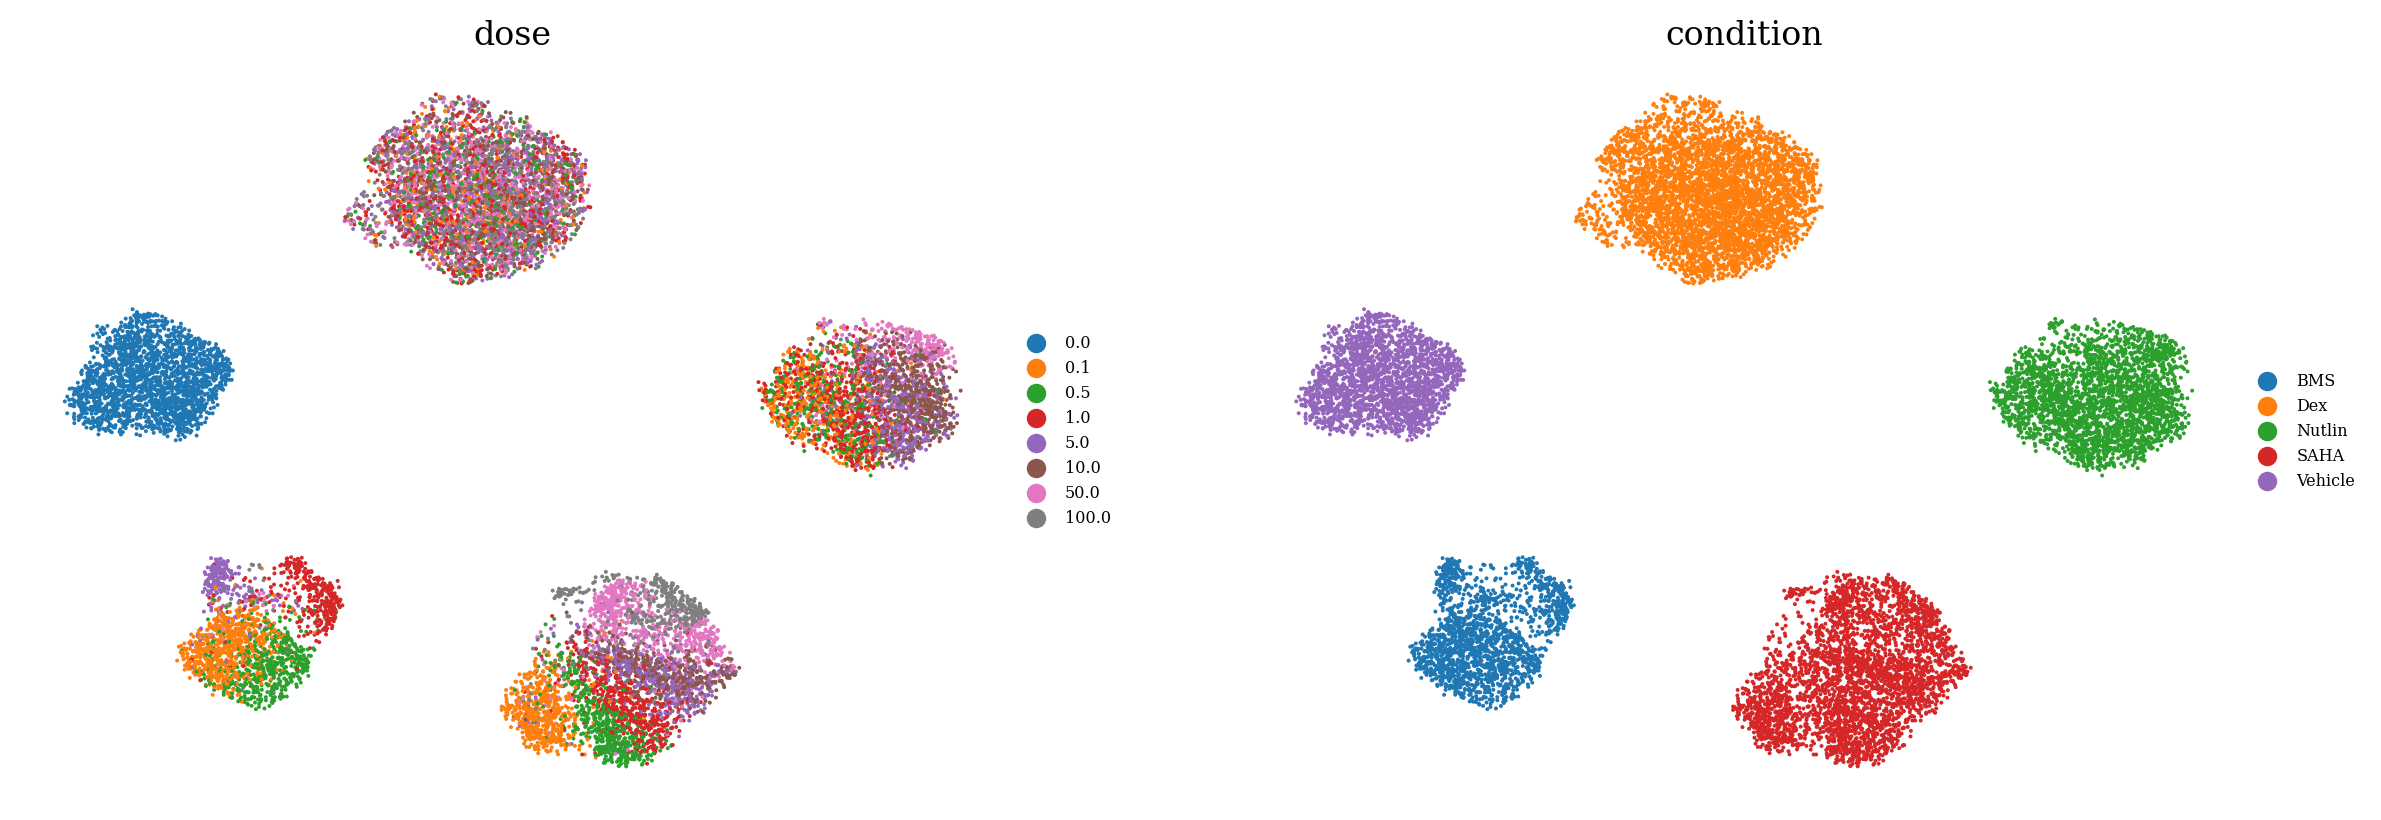

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

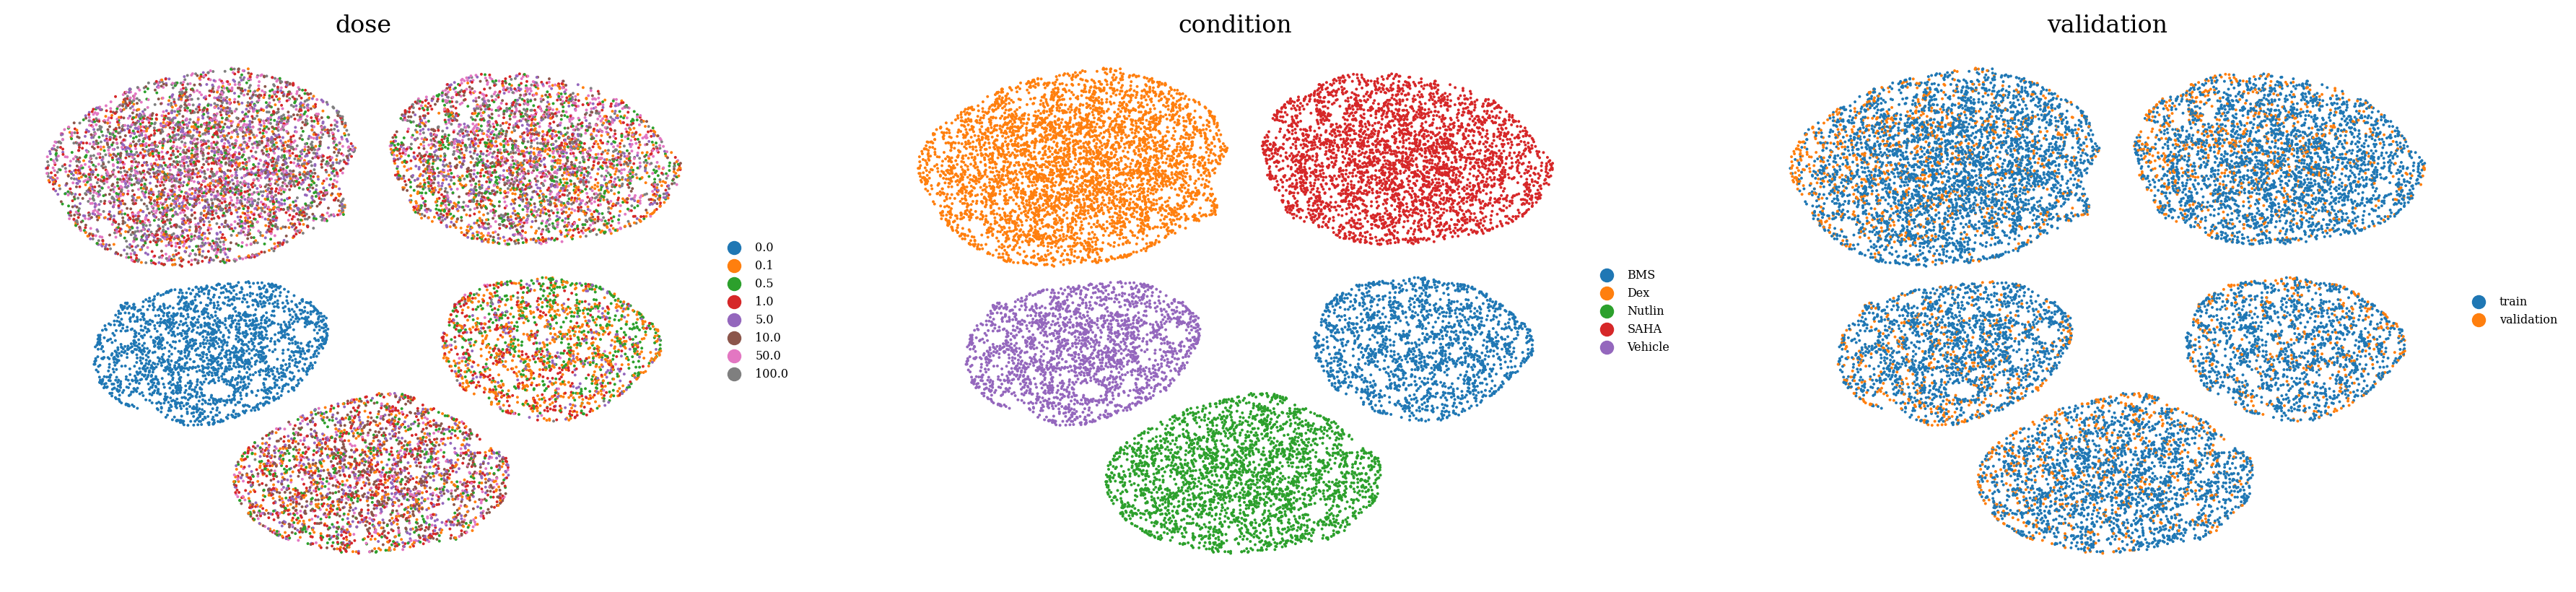

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )